In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

Júlia Togashi de Miranda

Gabriel Souza Pinto Medeiros

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<blockquote> The SVM problem in the primal space, following:

$$\underset{w, b,\xi}{\mathrm{min}} \quad \frac{1}{2}||w||^2+ C \sum_{i=1}^{n} \xi _i$$

Such that:

$$y_i(w^Tx_i+b)\ge 1 - \xi_i \quad i=1,...,n\\
\xi_i \ge 0 \quad i=1,...,n$$

For the kernel SVM, the data is transformed according a nonlinear feature map $\phi$ : $\mathbb{X} \rightarrow \mathbb{F}$. Then, the SVM is applied in this new feature space. <br>

Thus, the equation above can be rewritten to contemplate this transformation:

$$\underset{w, b,\xi}{\mathrm{min}} \quad \frac{1}{2}||w||^2+ C \sum_{i=1}^{n} \xi _i\\
y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+b)\ge 1 - \xi_i \quad i=1,...,n\\
\xi_i \ge 0 \quad i=1,...,n$$

The constraints can be written as: 

$$\xi_i = max(0,1-y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+b))$$

That is the same as:
$$\xi_i = [1-y_i(( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle+b)]_+$$

Therefore, if $\xi_i$ is substituted in the first equation, the primal problem can be written as described if $b \equiv w_0$:

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<blockquote> The loss applied in an SVM is known as the regularized Hinge loss, defined by the Hinge function: $(0, 1-x)_+$, which is convex. The phrase: "an SVM minimizes the classification error using a convex upper bound" references the Hinge's convex upper bound. This is relevant because it is a function that penalizes incorrect classifications, and as such it does not incur in loss when a datapoint is correctly classified, thus stopping overwhelmingly "easy" to classify datapoints from skewing the boundaries, unlike, for example, Naive Bayes. Intuitively, a function that penalizes incorrect classifications is be the indicator function, which, for example,  could take positive values when incorrectly classified and zero when correctly classified. But this function is not convex and as such cannot be minimized, so because the Hinge loss penalizes missclassifications and because of its convex upper bound, it can minimize classification error.

## Example of using SVC (originally in ```svm_script.py```)

In [3]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

<IPython.core.display.Javascript object>


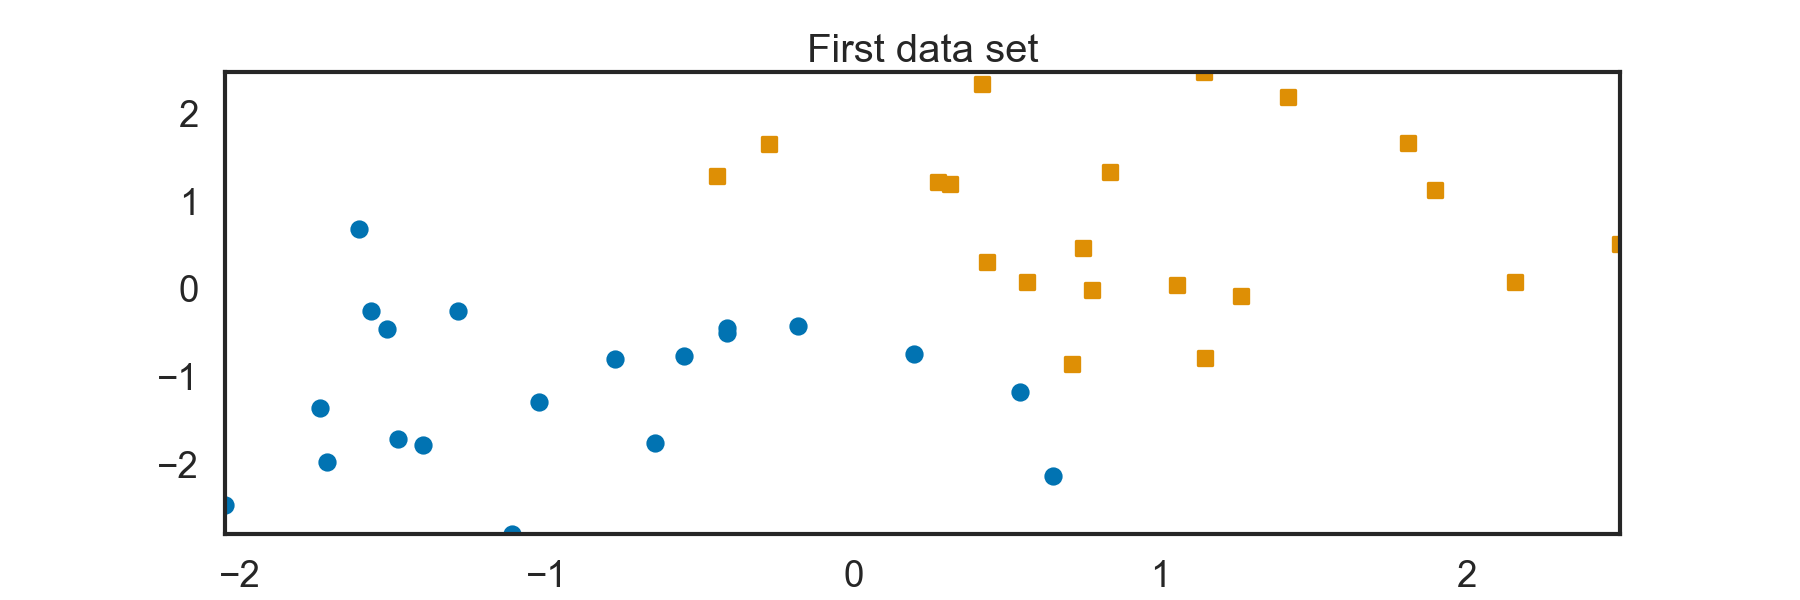

Score : 1.0


<IPython.core.display.Javascript object>


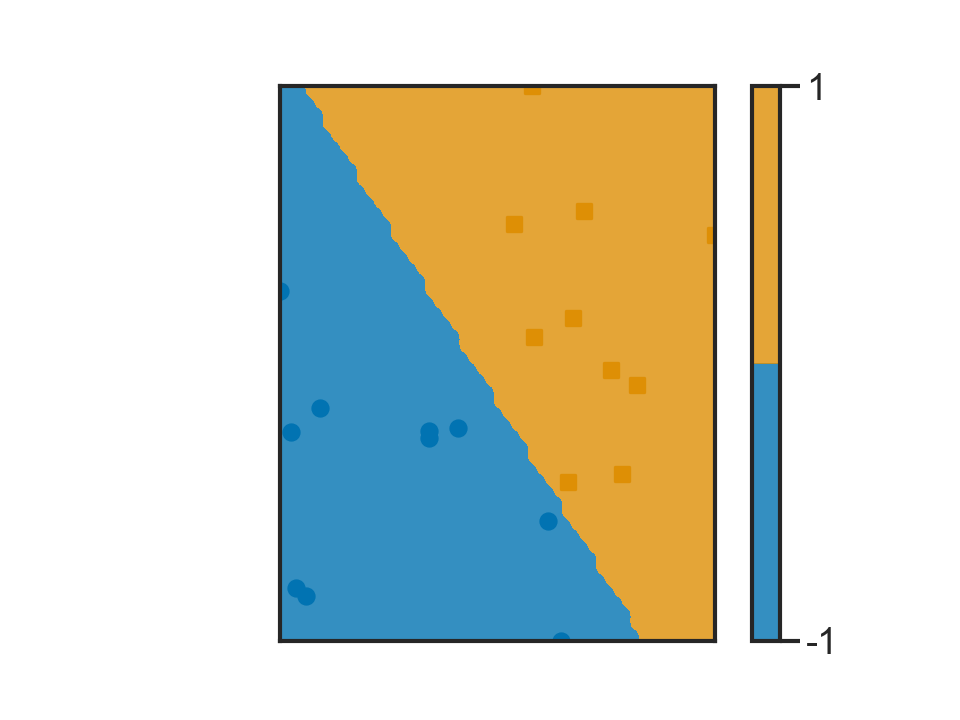

In [4]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

<IPython.core.display.Javascript object>


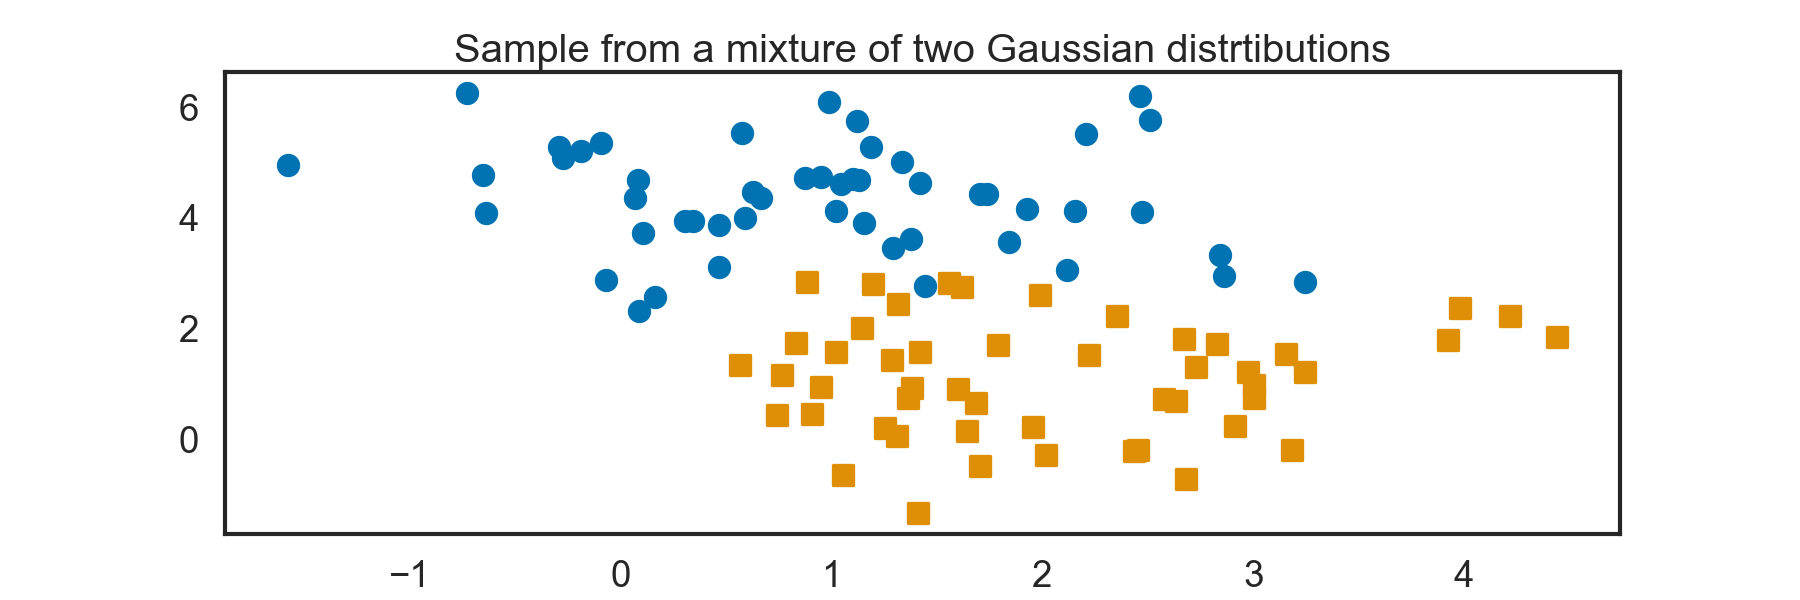

In [5]:
# using the function make_blobs to draw samples
X, y, centers = make_blobs(n_samples=100, centers=2, n_features=2,random_state=0, return_centers=True)

symlist = ['o', 's', '*', 'p', '+', 'x', 'D', 'v', '-', '^']
color_blind_list = sns.color_palette("colorblind")

plt.figure(figsize=(15,5))
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                 marker=symlist[int(label)])
plt.title("Sample from a mixture of two Gaussian distrtibutions")
plt.show()


In [142]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale data (each feature will have average equal to 0 and unit variance)
X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [193]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
mn1 = multivariate_normal(mean=centers[0], cov=[[1, 0], [0, 1]]) # generates blue distribution
mn2 = multivariate_normal(mean=centers[1], cov=[[1, 0], [0, 1]]) # Generates orange distribution

n = 5000 # number of generated points
count = 0 # number of missclassified points
for i in range(n):
    val = mn1.rvs() # get a random value from the first distribution
    if mn2.cdf(val) >= mn1.cdf(val): # see if missidentified
        count += 1
    val = mn2.rvs() # get a random value from second distribution
    if mn2.cdf(val) <= mn1.cdf(val): # see if missidentified
        count += 1

print(f'The bayes risk obtained was {count/(2*n)}')

The bayes risk obtained was 0.1674


**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<blockquote> As can be seen in the graphs bellow, increasing the value of the parameter C is equivalent to make the margin narrower.<br>
    
For the SVM in a nonlinear separable case, the C parameter is introduced as a penalization for misclassifying a point. The problem can be written as follows:
    
$$\underset{w, b,\xi}{\mathrm{min}} \quad \frac{1}{2}||w||^2+ C \sum_{i=1}^{n} \xi _i$$

Such that:

$$y_i(w^Tx_i+b)\ge 1 - \xi_i \quad i=1,...,n\\
\xi_i \ge 0 \quad i=1,...,n$$

Therefore, the C constant is the tradeoff between minimizing the models complexity (maximizing the margins) and allowing misclassifications.

<IPython.core.display.Javascript object>


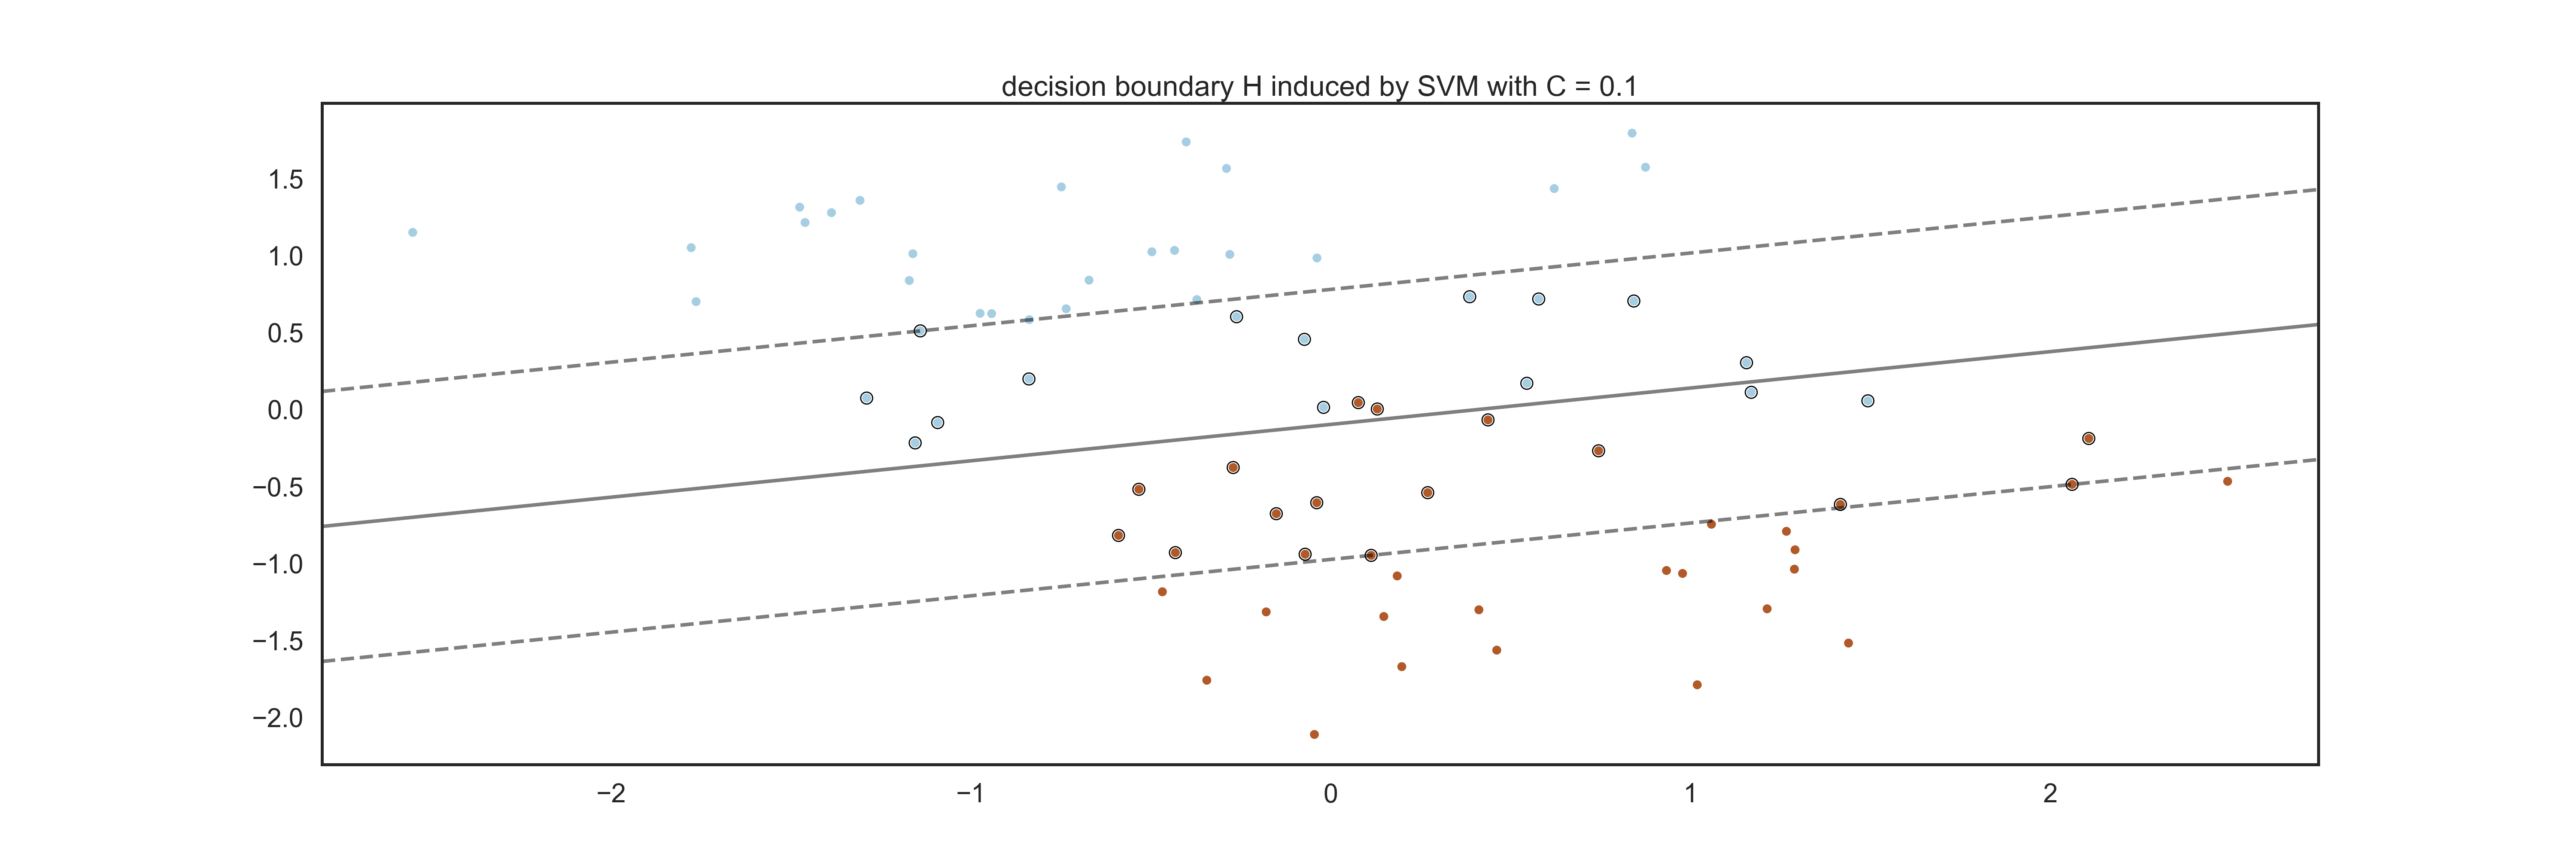

<IPython.core.display.Javascript object>


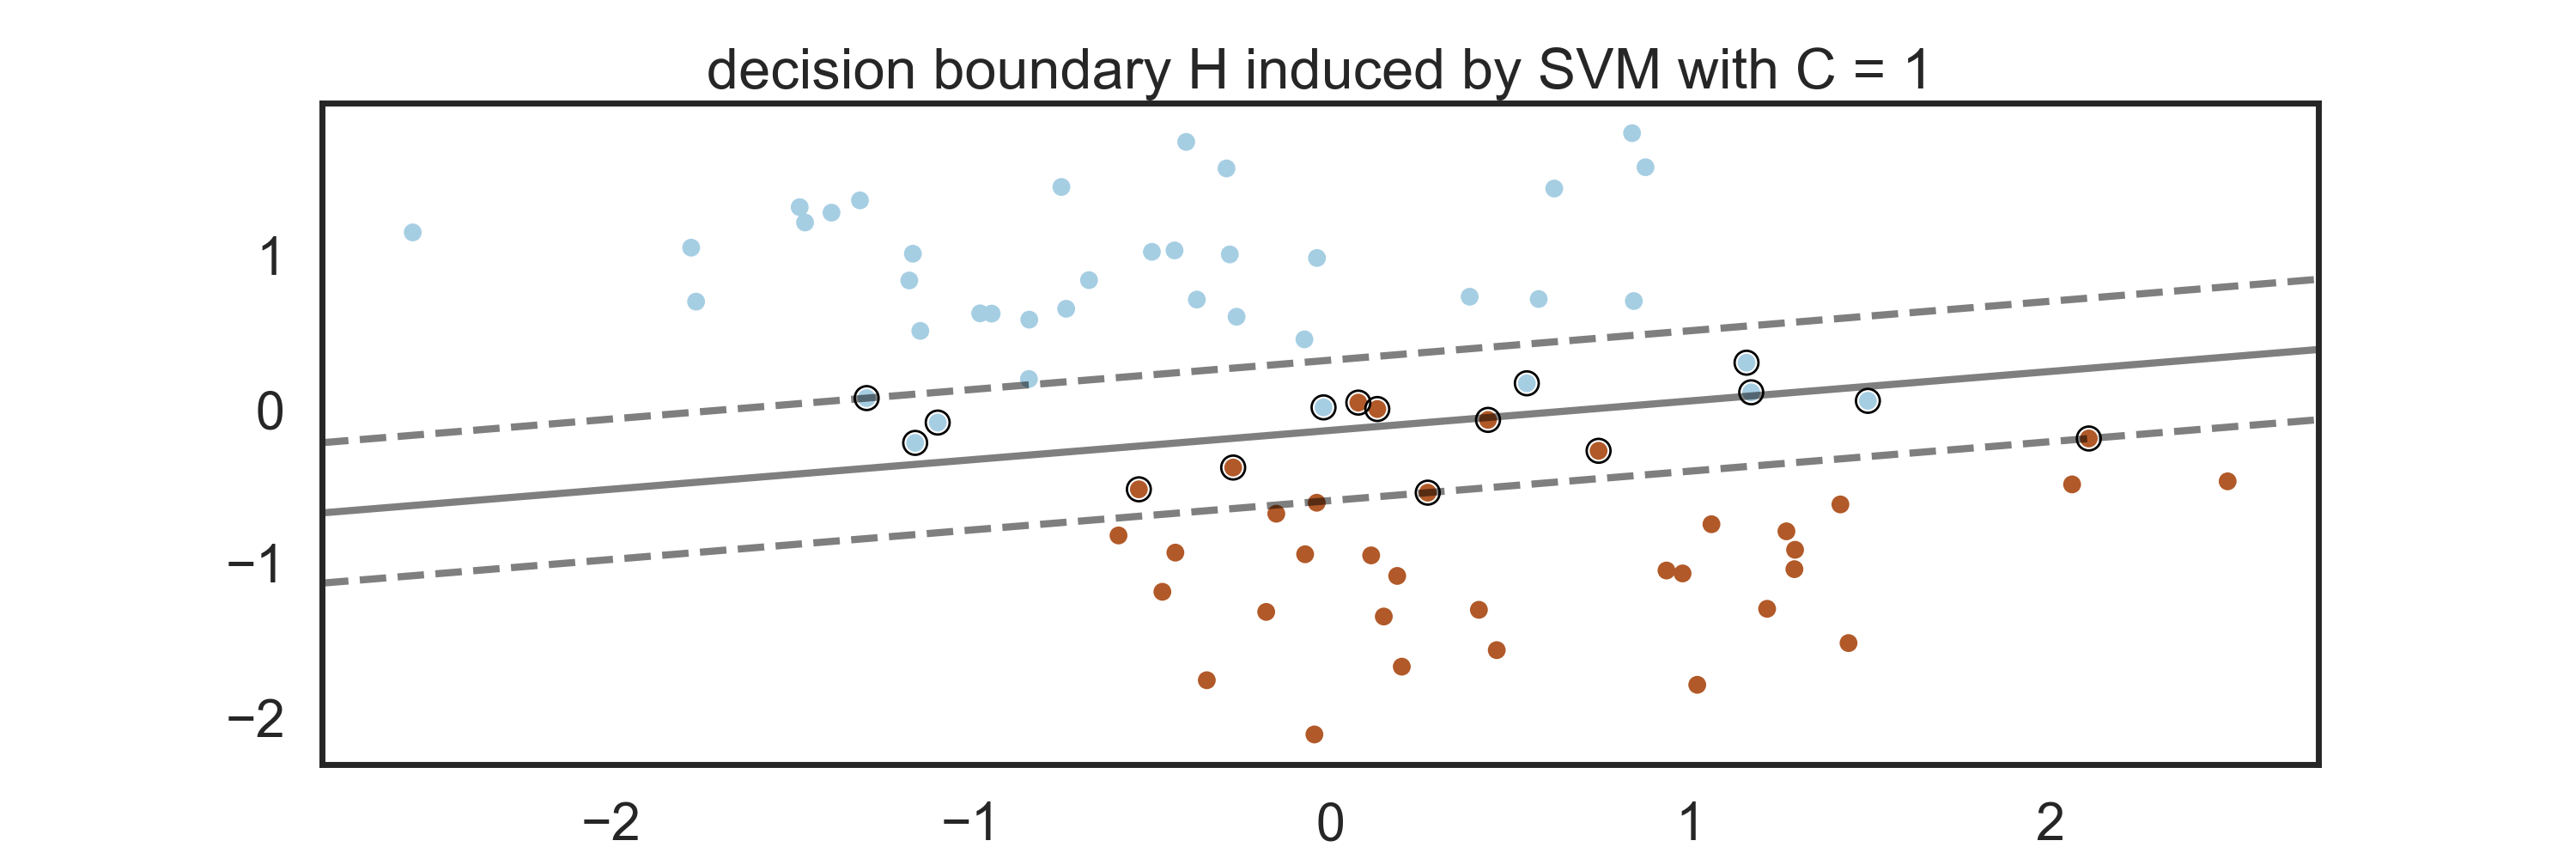

<IPython.core.display.Javascript object>


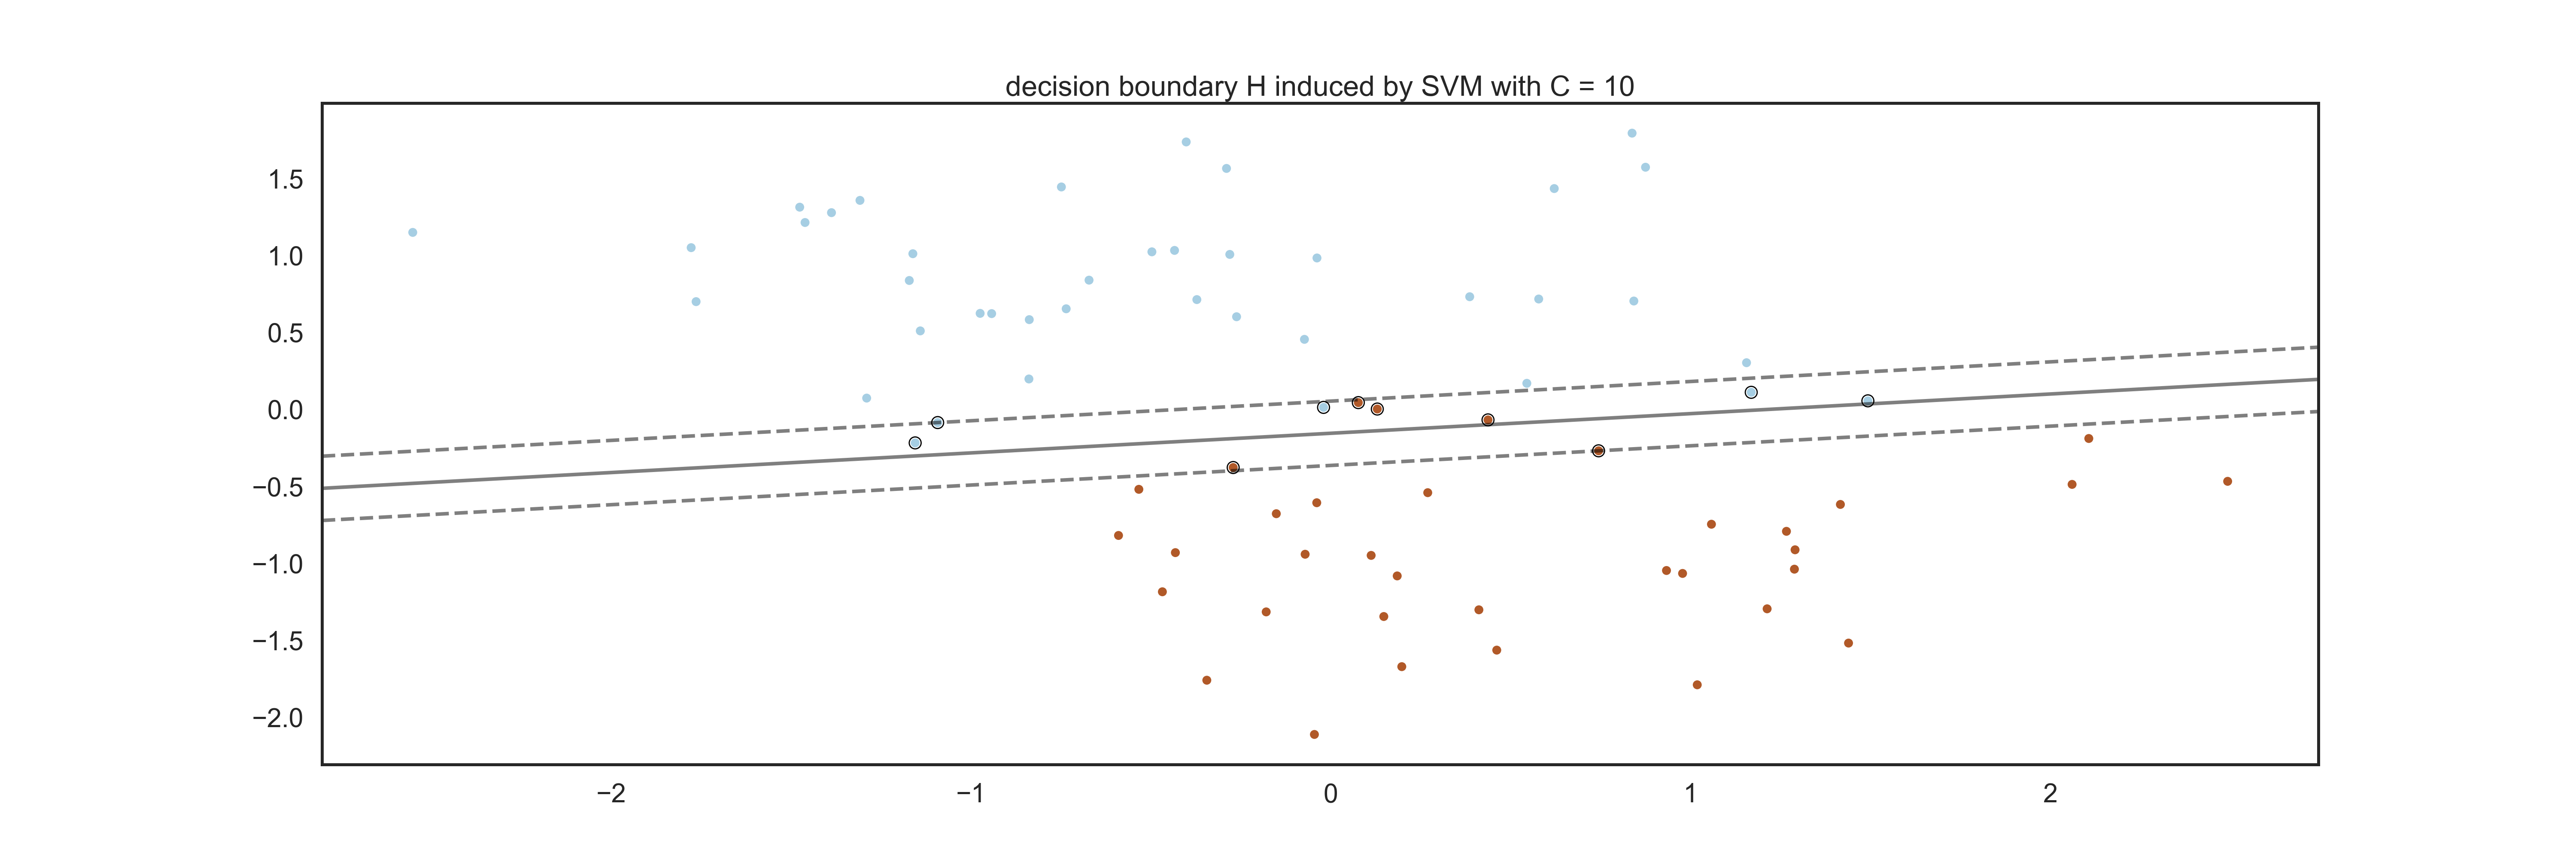

<IPython.core.display.Javascript object>


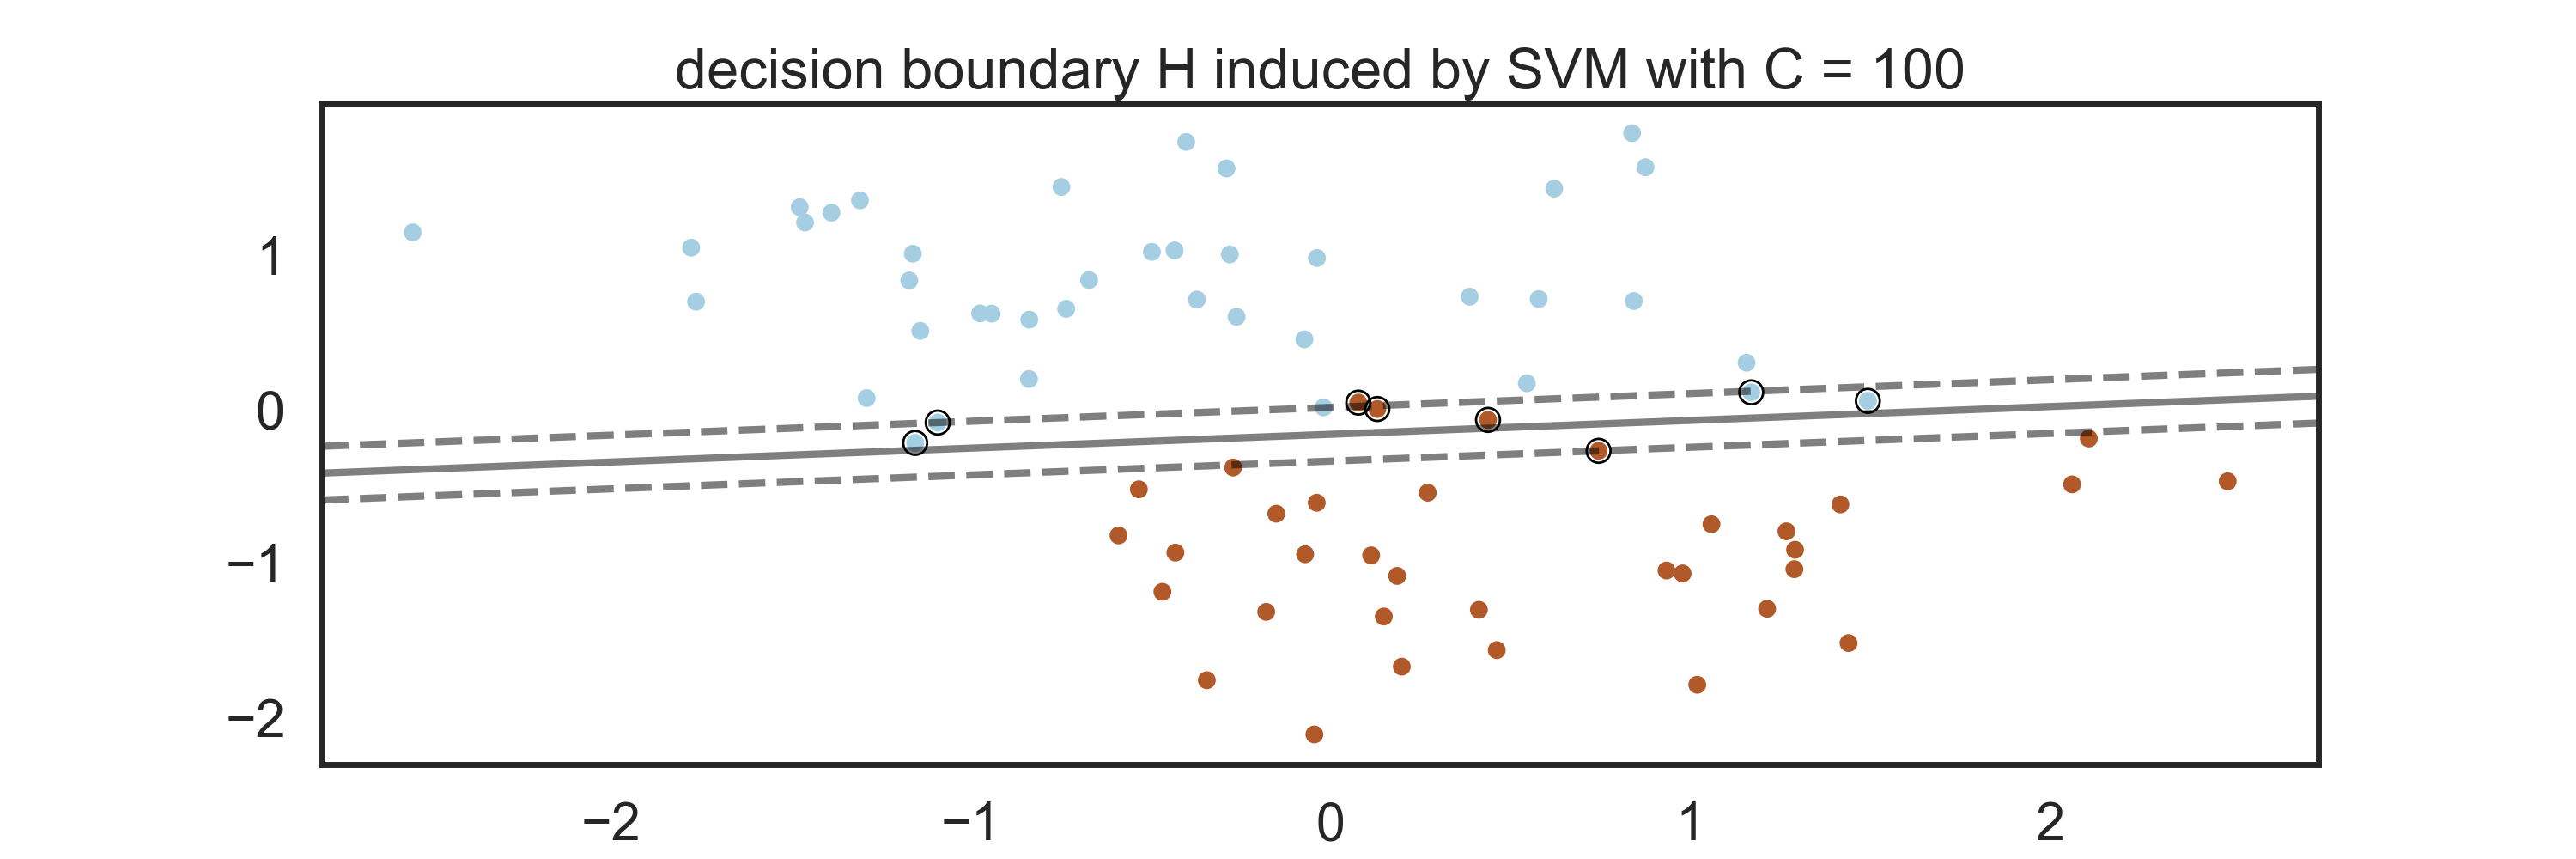

In [25]:
plt.close('all')
for i in [0.1,1,10,100]:
    
    lsvm = SVC(C=i,kernel='linear')
    lsvm.fit(X_train,y_train)
    
    plt.figure(figsize=(15,5))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = lsvm.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(lsvm.support_vectors_[:, 0], lsvm.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.title("decision boundary H induced by SVM with C = "+str(i))
    plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

<IPython.core.display.Javascript object>


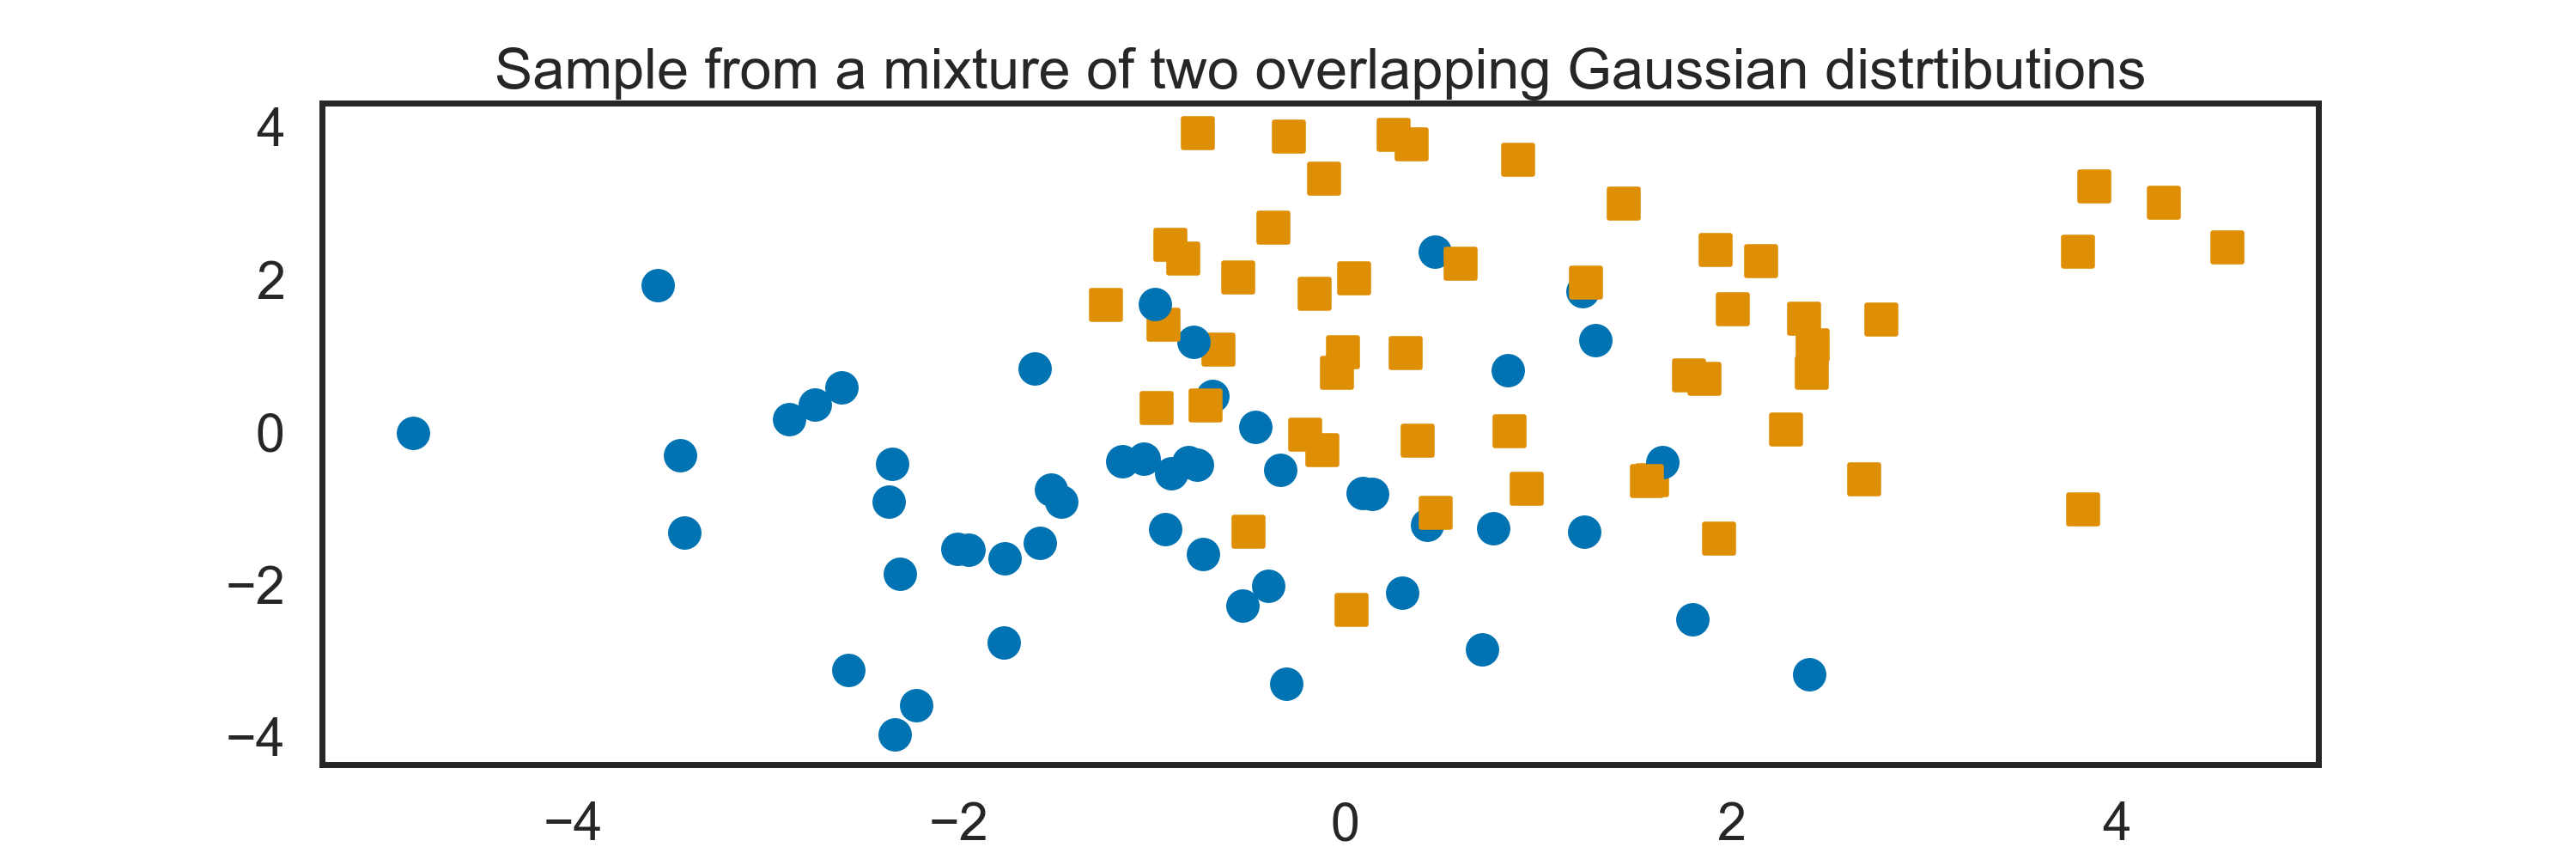

In [26]:
# Generate data and verify graphically that the two classes overlap

# using the function make_blobs to draw overlapping distributions
plt.close('all')
X, y = make_blobs(n_samples=100, centers=np.array([[-1,-1],[1,1]]), cluster_std=1.5, n_features=2,random_state=0)

plt.figure(figsize=(15,5))
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                 marker=symlist[int(label)])
plt.title("Sample from a mixture of two overlapping Gaussian distrtibutions")
plt.show()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale data (each feature will have average equal to 0 and unit variance)
X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Best training Score: 0.8800000000000001
Best training params: {'C': 0.01}


<IPython.core.display.Javascript object>


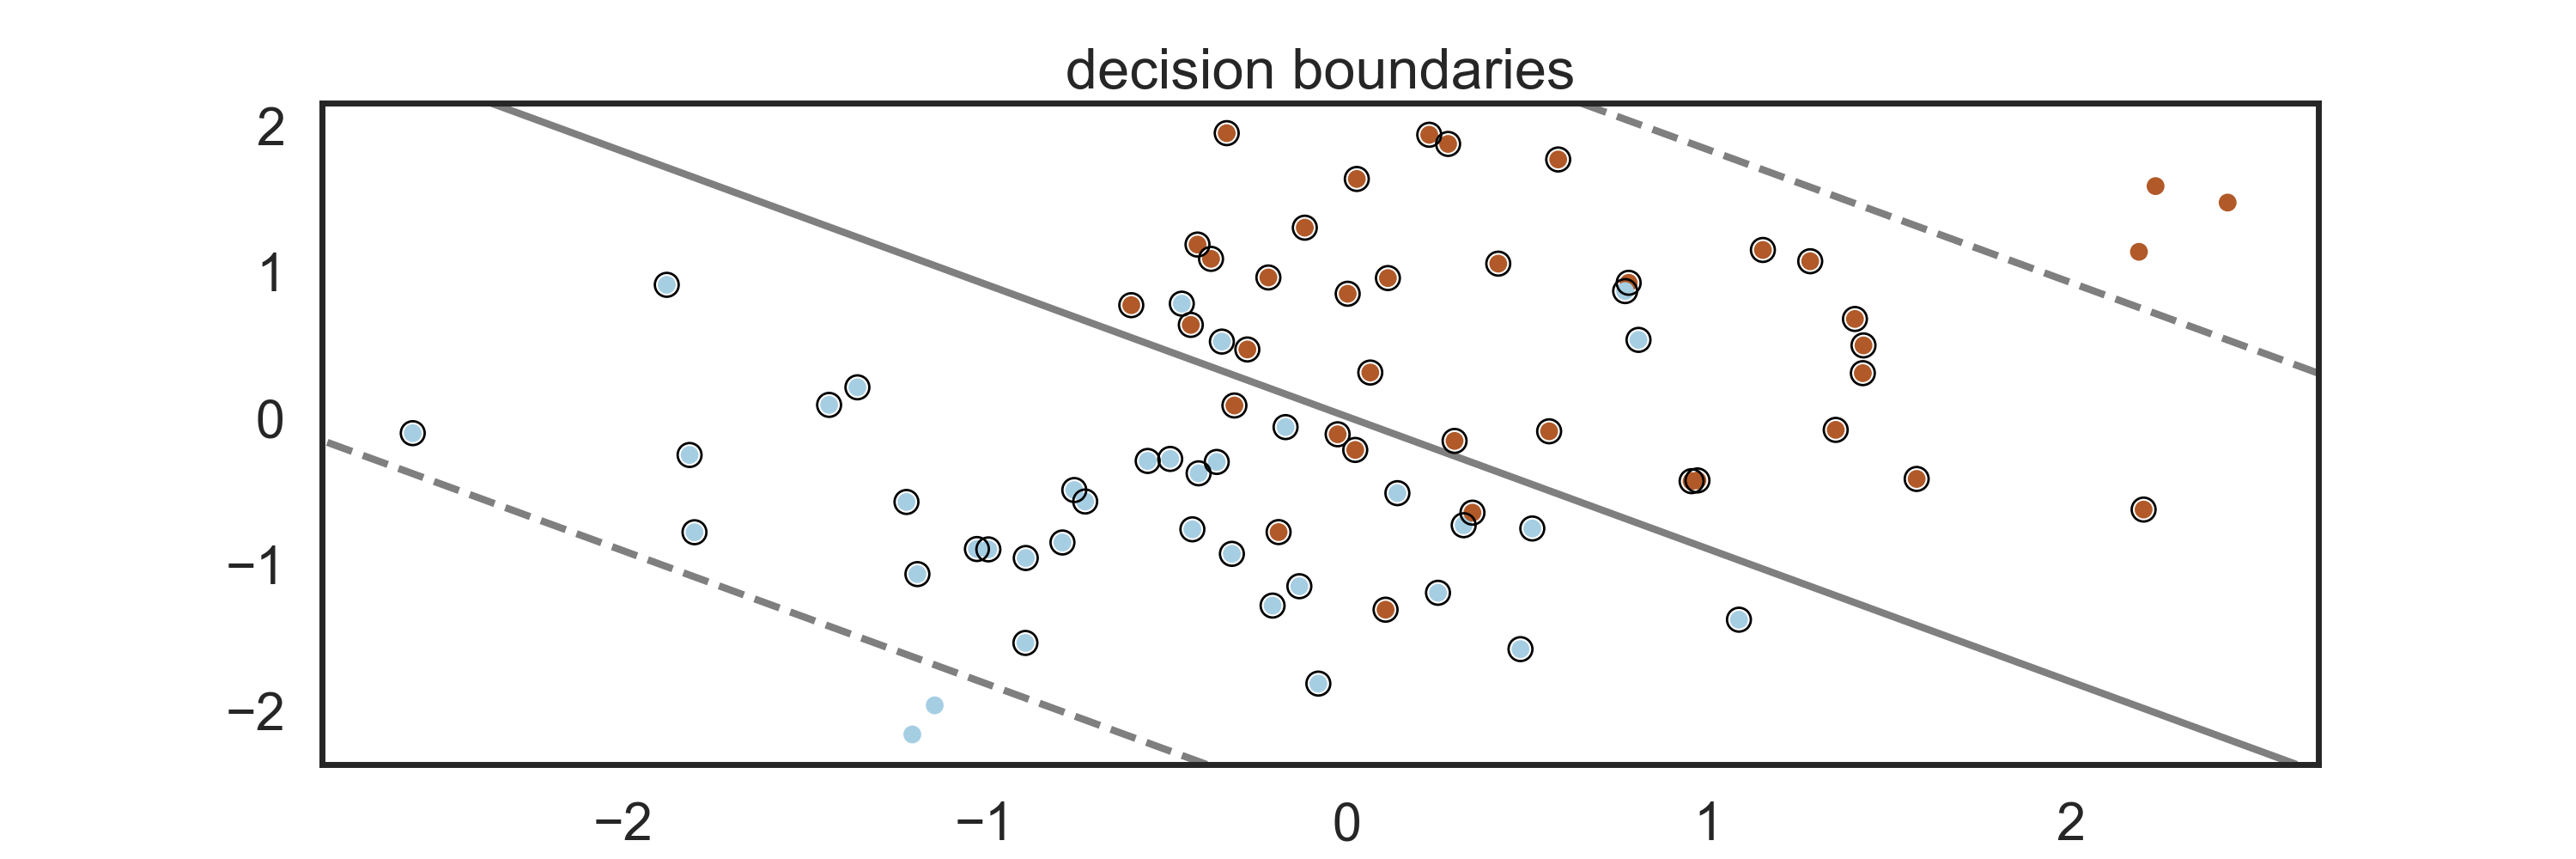

In [27]:
# Find the best working C with a 5-fold cross-validation
plt.close('all')
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
lsvm = SVC(kernel='linear')
grid_lsvm = GridSearchCV(lsvm, p_grid_lsvm, cv=5)
grid_lsvm.fit(X_train, y_train)
best_par=grid_lsvm.best_params_
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))

lsvm = SVC(C=best_par['C'],kernel='linear')
lsvm.fit(X_train,y_train)

plt.figure(figsize=(15,5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = lsvm.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(lsvm.support_vectors_[:, 0], lsvm.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

ax.set_title("decision boundaries")
plt.show()

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

<blockquote> The problem of overfitting happens when an over complex model is used, therefore, the model starts to fit the noise in the training data set. When that happens, it loses its power of generalization, resulting in poor results on the test set.<br><br>
    
Below, multiple tests were done, each time with a different combination of C and Gamma parameters. The graph shows the test and train score for each test. It can be seen that the cases where the train score was best, in fact had poor test score, that is, were indeed cases of overfitting.


<IPython.core.display.Javascript object>


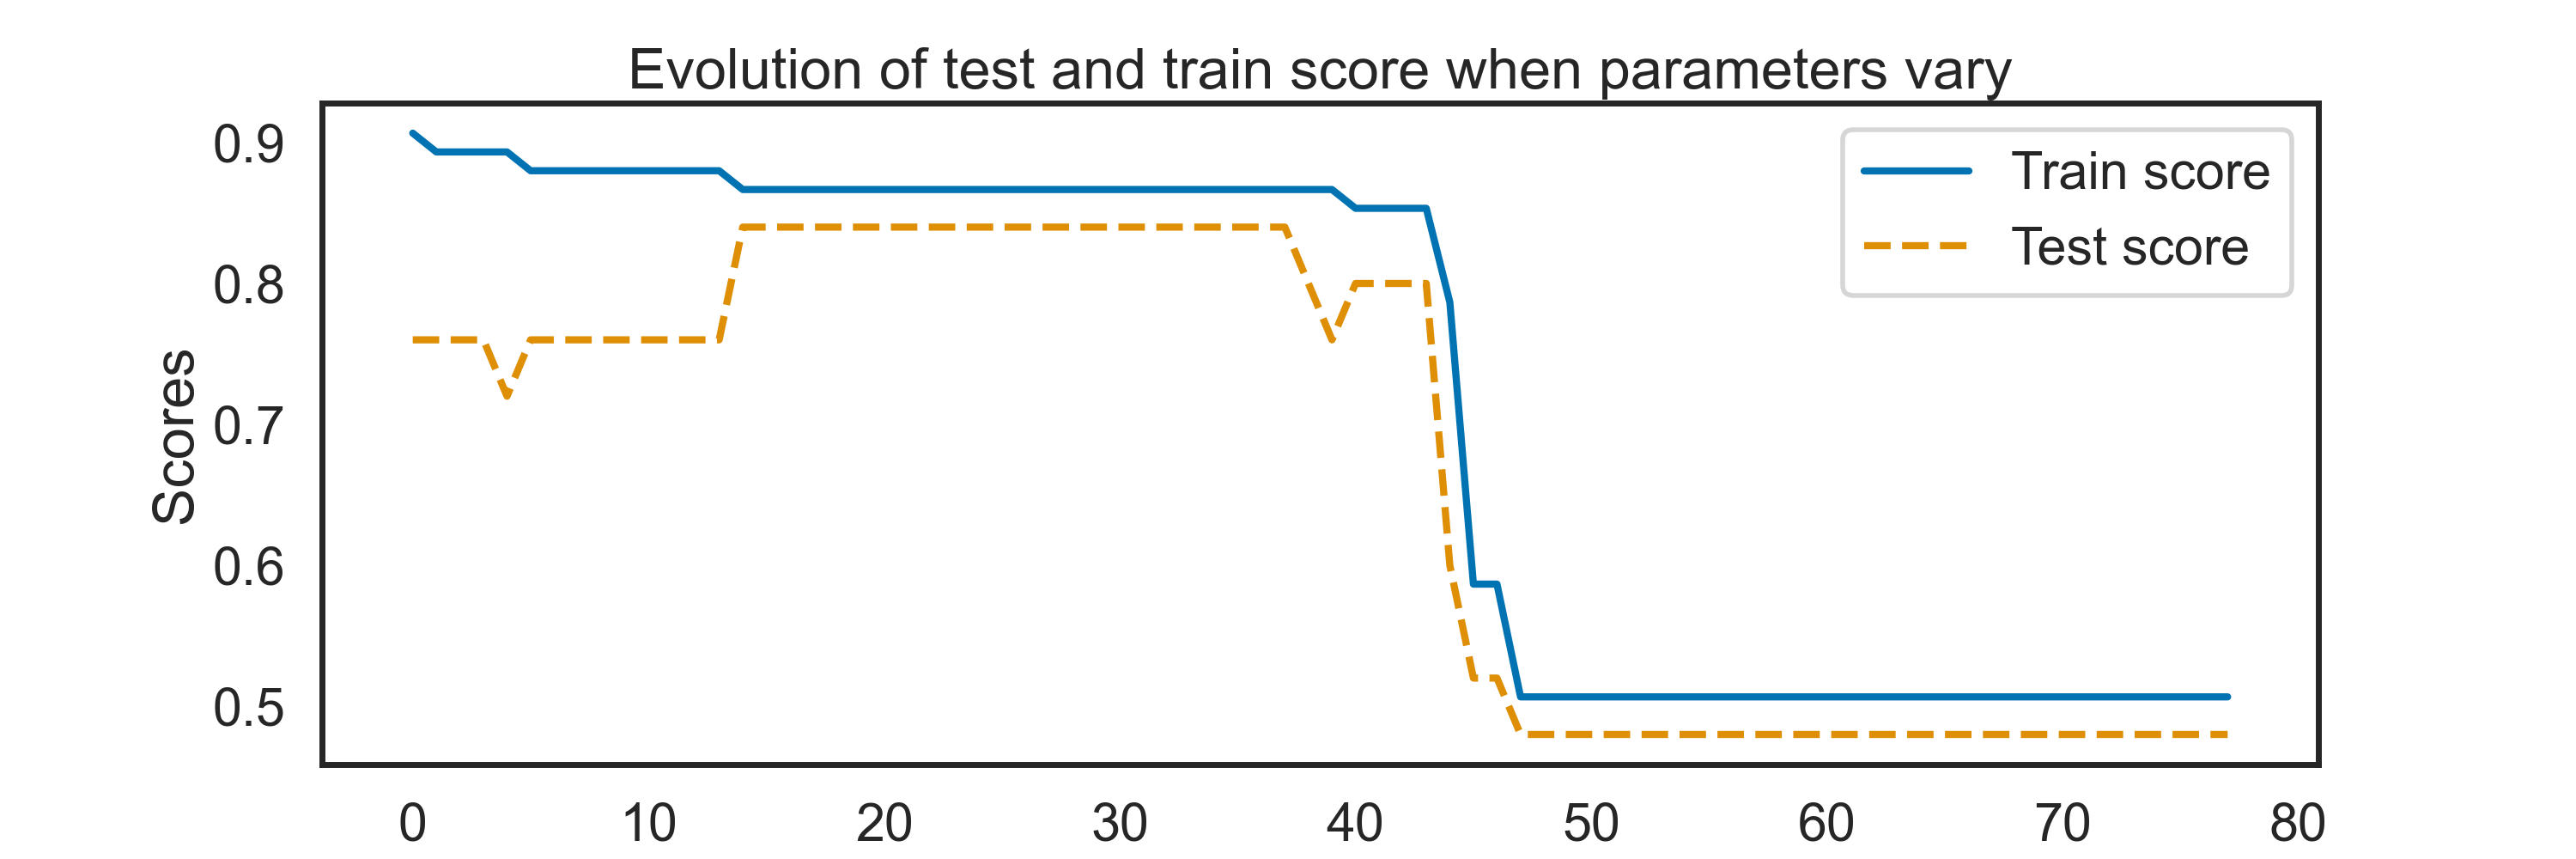

In [30]:
# Vary the parameter of the kernel and check the difference between training and testing scores
plt.close('all')
C = [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]
gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]

traning_score=[]
test_score=[]

for g in gamma:
    for c in C:
        lsvm = SVC(kernel='rbf', C=c, gamma= g)
        lsvm.fit(X_train,y_train)
        # Score in the train set
        traning_score.append(lsvm.score(X_train,y_train))
        # Score in the test set
        test_score.append(lsvm.score(X_test,y_test))

x = np.arange(0,len(traning_score))
traning_score, test_score = zip(*sorted(zip(traning_score, test_score),reverse=True))

plt.figure(figsize=(15,5))
plt.plot(x,traning_score, label="Train score")
plt.plot(x,test_score, label="Test score", ls='--')
plt.legend(loc=1)
plt.xlabel('Fitting with different parameters')
plt.ylabel('Scores')
plt.title('Evolution of test and train score when parameters vary')

plt.show()
    

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

<IPython.core.display.Javascript object>


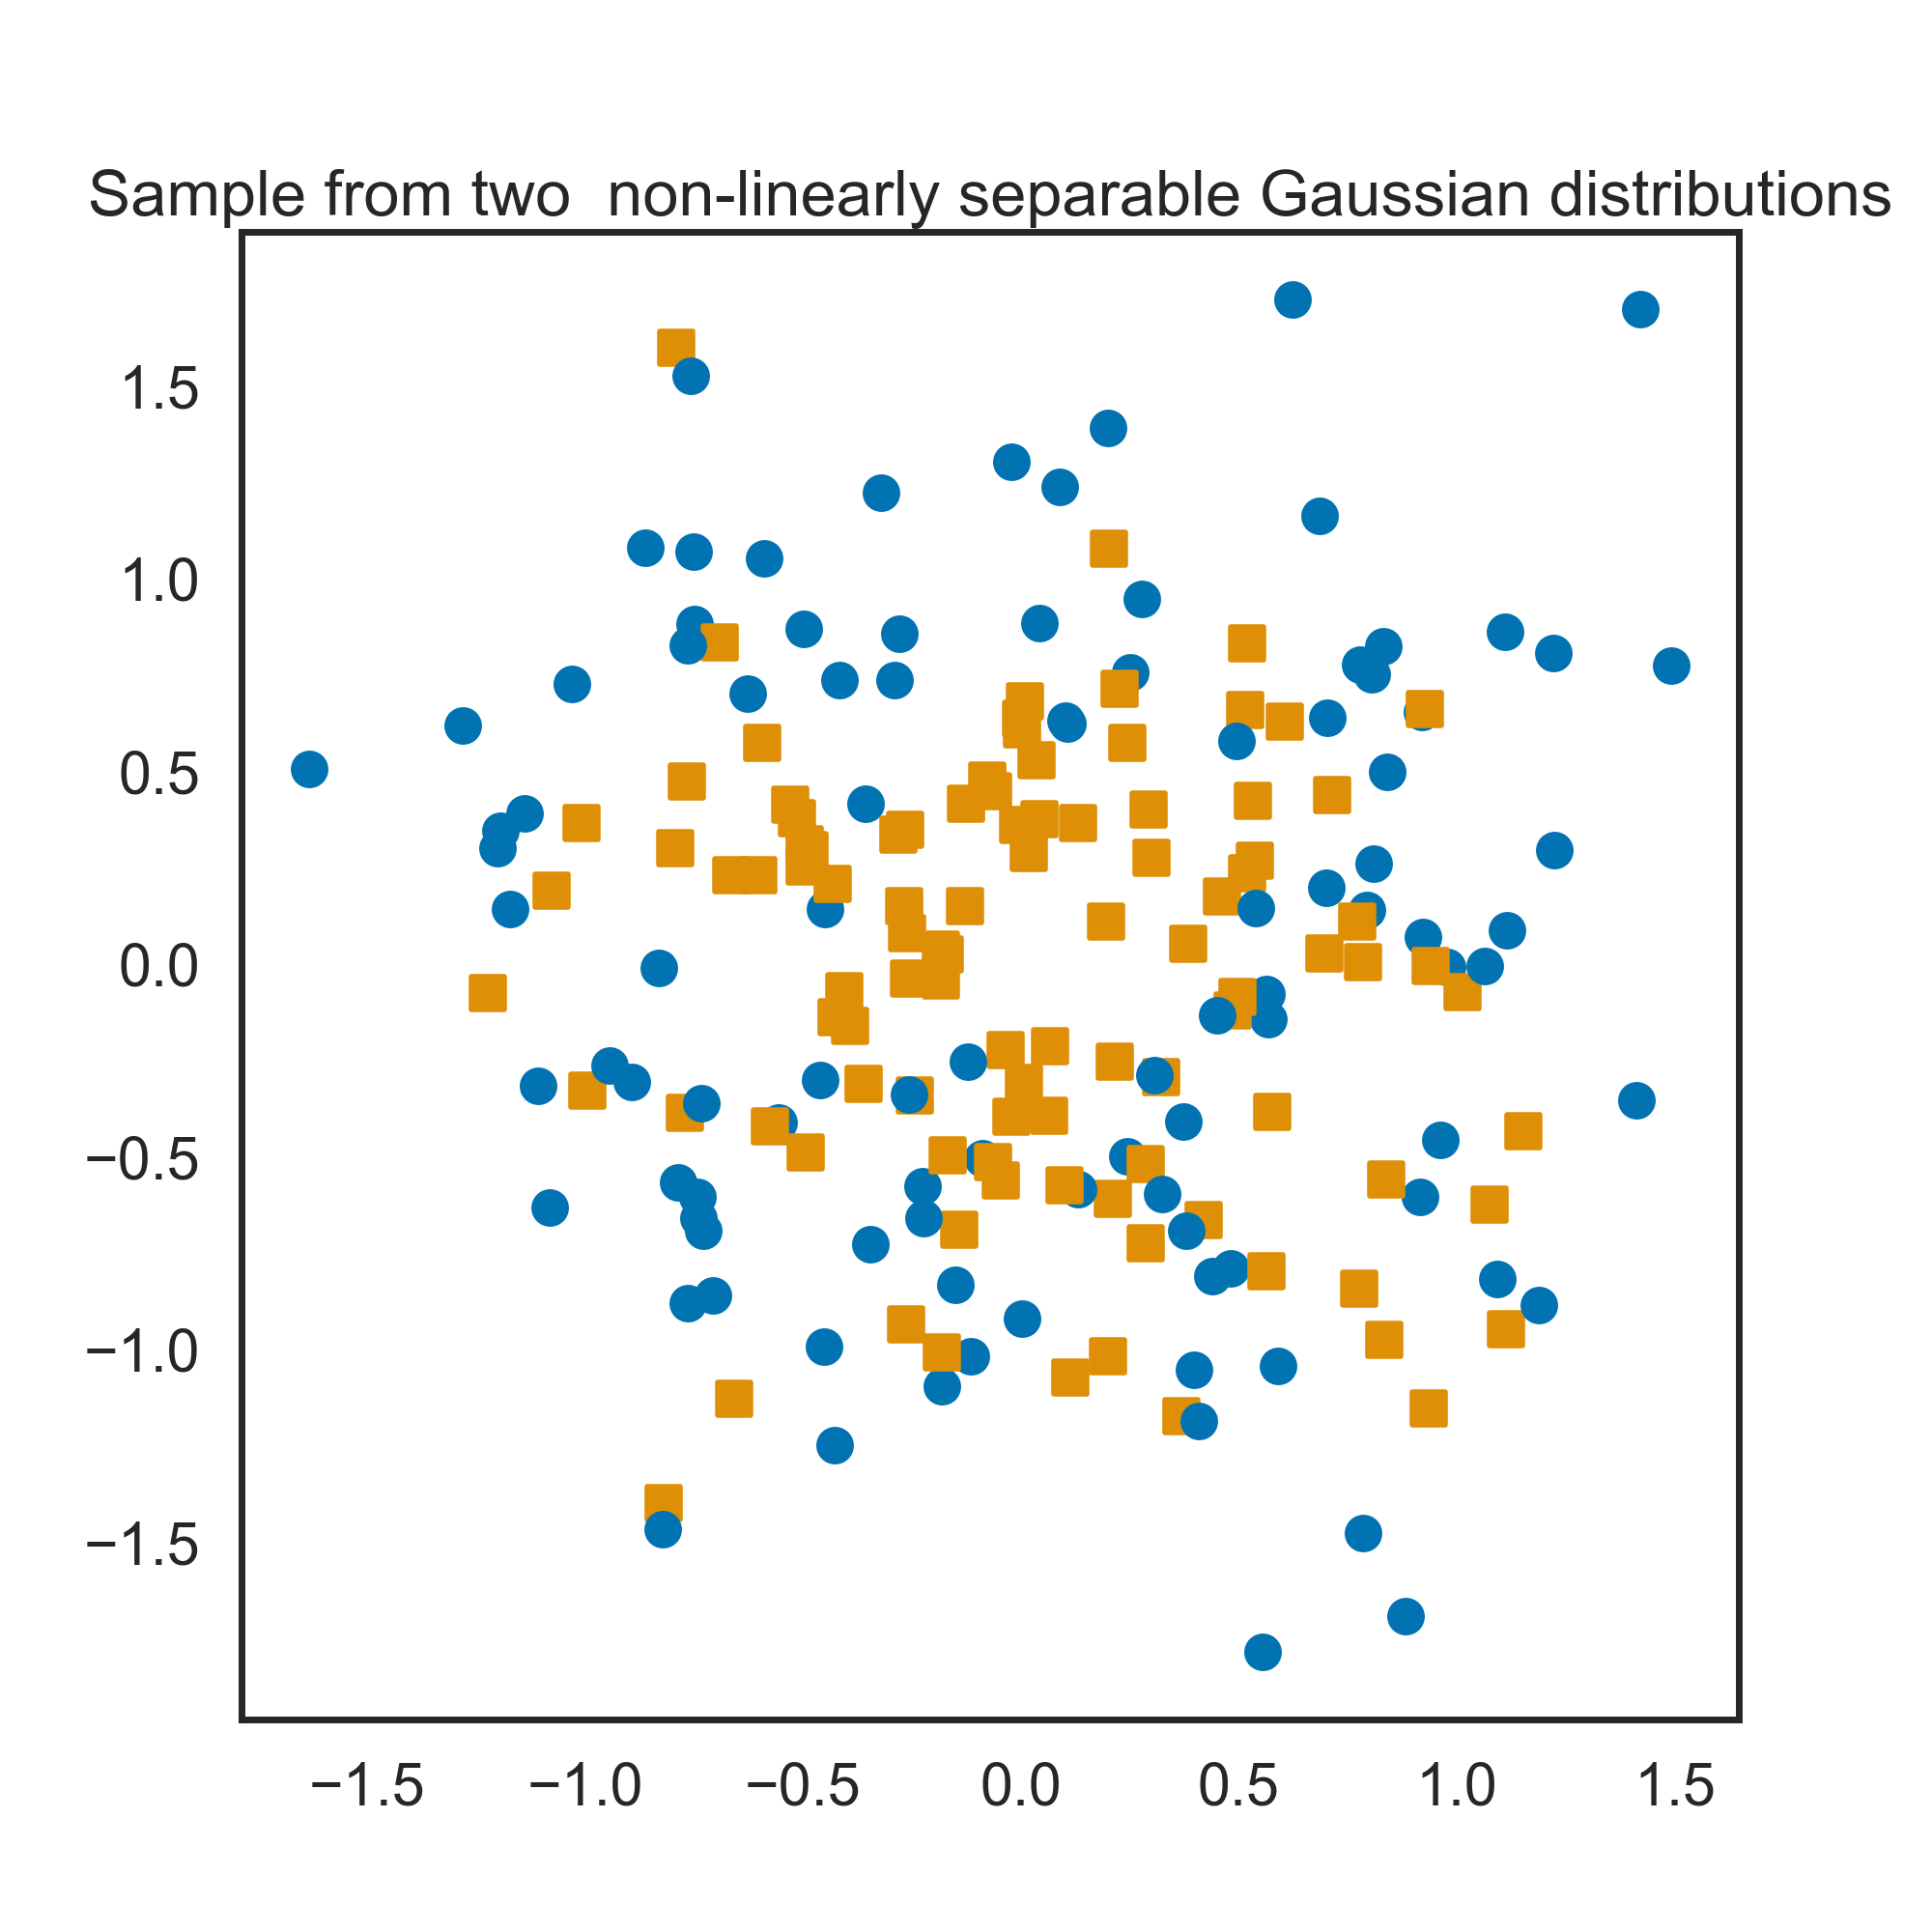

In [376]:
# using the function make_blobs to draw samples
plt.close('all')
circle_std = 0.4
X, y = make_circles(n_samples=200, factor=.5,noise=circle_std)

symlist = ['o', 's', '*', 'p', '+', 'x', 'D', 'v', '-', '^']
color_blind_list = sns.color_palette("colorblind")

plt.figure(figsize=(10,10))
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                 marker=symlist[int(label)])
plt.title("Sample from two  non-linearly separable Gaussian distributions")
plt.show()

In [377]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale data (each feature will have average equal to 0 and unit variance)
X_train
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

Fitting Non-linear SVM to the training set
Best training Score: 0.64
Best training params: {'C': 3, 'gamma': 0.1}
Test score:  0.7


<IPython.core.display.Javascript object>


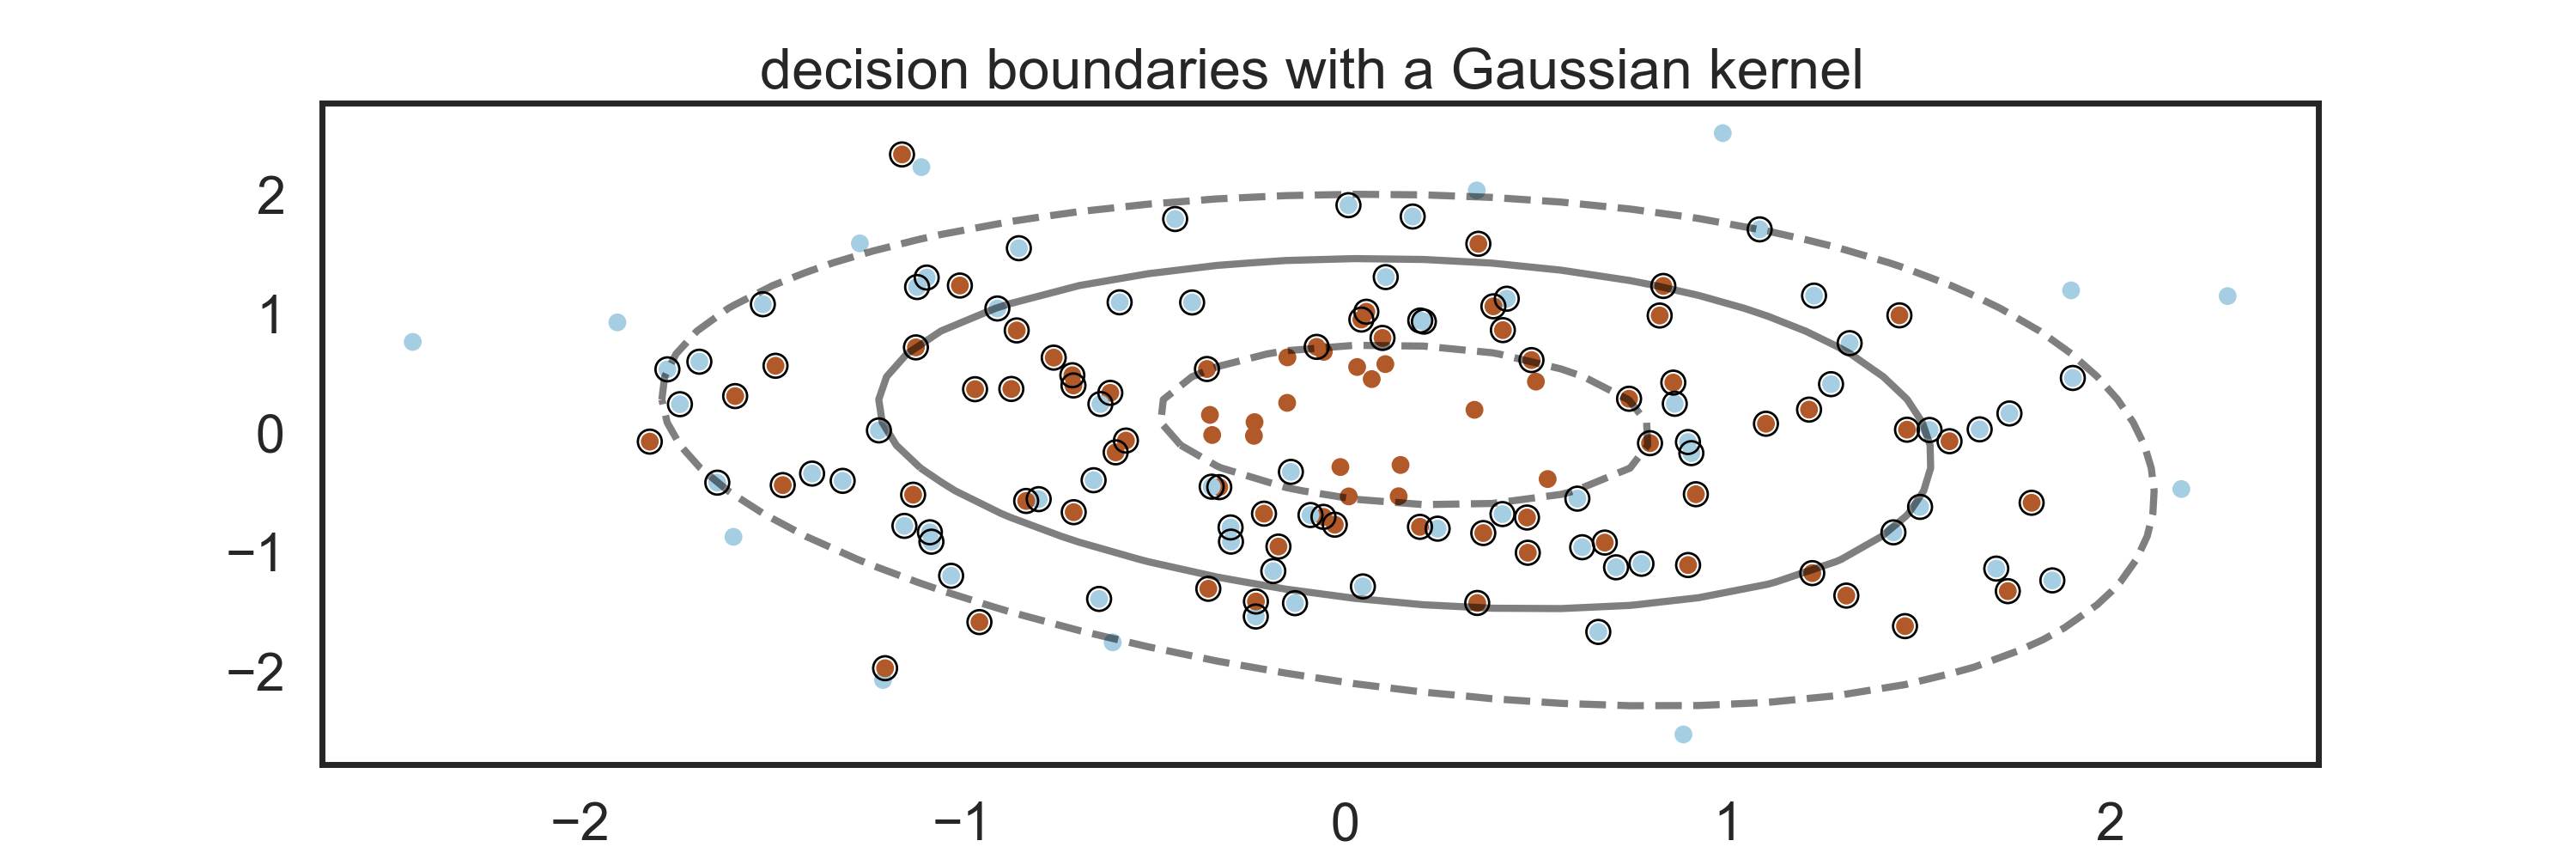

In [378]:
print("Fitting Non-linear SVM to the training set")
plt.close('all')

p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
nlsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(nlsvm, p_grid_nlsvm, cv=5, scoring="accuracy")
grid_nlsvm.fit(X_train, y_train)  
best_par=grid_nlsvm.best_params_
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

lsvm = SVC(C=best_par['C'],gamma=best_par['gamma'],kernel='rbf')
lsvm.fit(X_train,y_train)
print("Test score: ",lsvm.score(X_test,y_test))

plt.figure(figsize=(15,5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = lsvm.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(lsvm.support_vectors_[:, 0], lsvm.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
ax.set_title("decision boundaries with a Gaussian kernel ")
plt.show()

Fitting Non-linear SVM to the training set
Best training Score: 0.6866666666666666
Best training params: {'C': 4, 'degree': 2}
Test score:  0.68


<IPython.core.display.Javascript object>


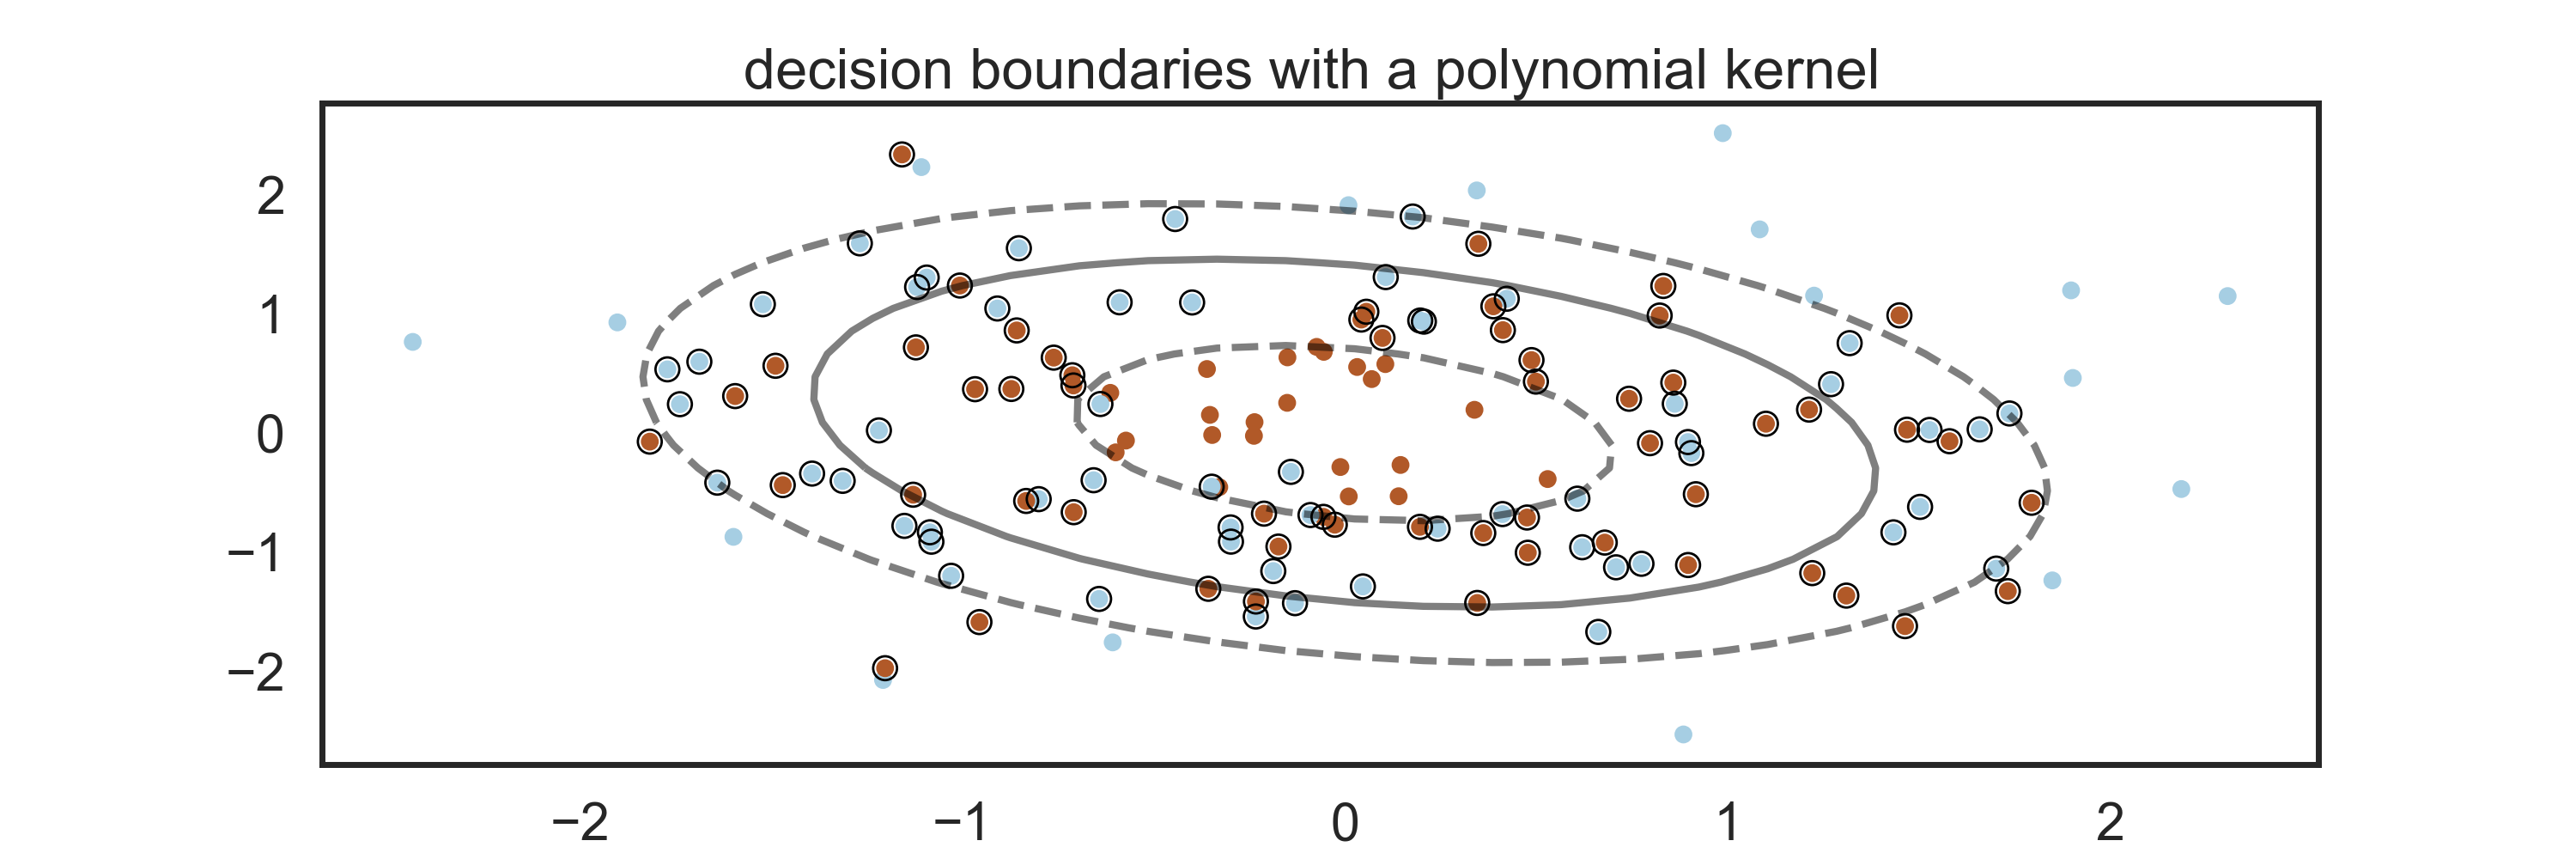

In [379]:
print("Fitting Non-linear SVM to the training set")
plt.close('all')

p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'degree' : [ 2, 3, 4, 5, 6], }
nlsvm = SVC(kernel='poly')
grid_nlsvm = GridSearchCV(nlsvm, p_grid_nlsvm, cv=5, scoring="accuracy")
grid_nlsvm.fit(X_train, y_train)  
best_par=grid_nlsvm.best_params_
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))

lsvm = SVC(C=best_par['C'],degree=best_par['degree'],kernel='poly')
lsvm.fit(X_train,y_train)

print("Test score: ",lsvm.score(X_test,y_test))

plt.figure(figsize=(15,5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = lsvm.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(lsvm.support_vectors_[:, 0], lsvm.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
ax.set_title("decision boundaries with a polynomial kernel ")
plt.show()

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

<blockquote> To compare the performance between different SVMs kernels: First, look for the best parameters in each case, that can be done using CV as seen above; Then, choose the model with the best score/ lowest error in the test set. If like in the case above, two or more models are able to adequately fit the data, the preference should be for the less complex.

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<blockquote> For this dataset, with a radius variance of 0.16 the training curve started very similar for both the test and train set, which makes sense, because the set used to train is a subset of the train set, later both of them tend to slightly below the value estimated by the Bayes predictor.

In [380]:
mn1 = multivariate_normal(mean=0.5, cov=[circle_std**(2)]) # generates blue distribution
mn2 = multivariate_normal(mean=1, cov=[circle_std**(2)]) # Generates orange distribution

n = 5000 # number of generated points
count = 0 # number of missclassified points
for i in range(n):
        val = mn1.rvs() # get a random value from the first distribution
        if val > 0.5:
            if  1-mn1.cdf(val) < mn2.cdf(val): # see if missidentified
                count += 1
        val = mn2.rvs() # get a random value from second distribution
        if val < 1:
            if 1-mn1.cdf(val) > mn2.cdf(val): # see if missidentified
                count += 1
bayes_naive = count/(2*n)
print(f'The bayes risk obtained was {bayes_naive}')

The bayes risk obtained was 0.2685


<IPython.core.display.Javascript object>


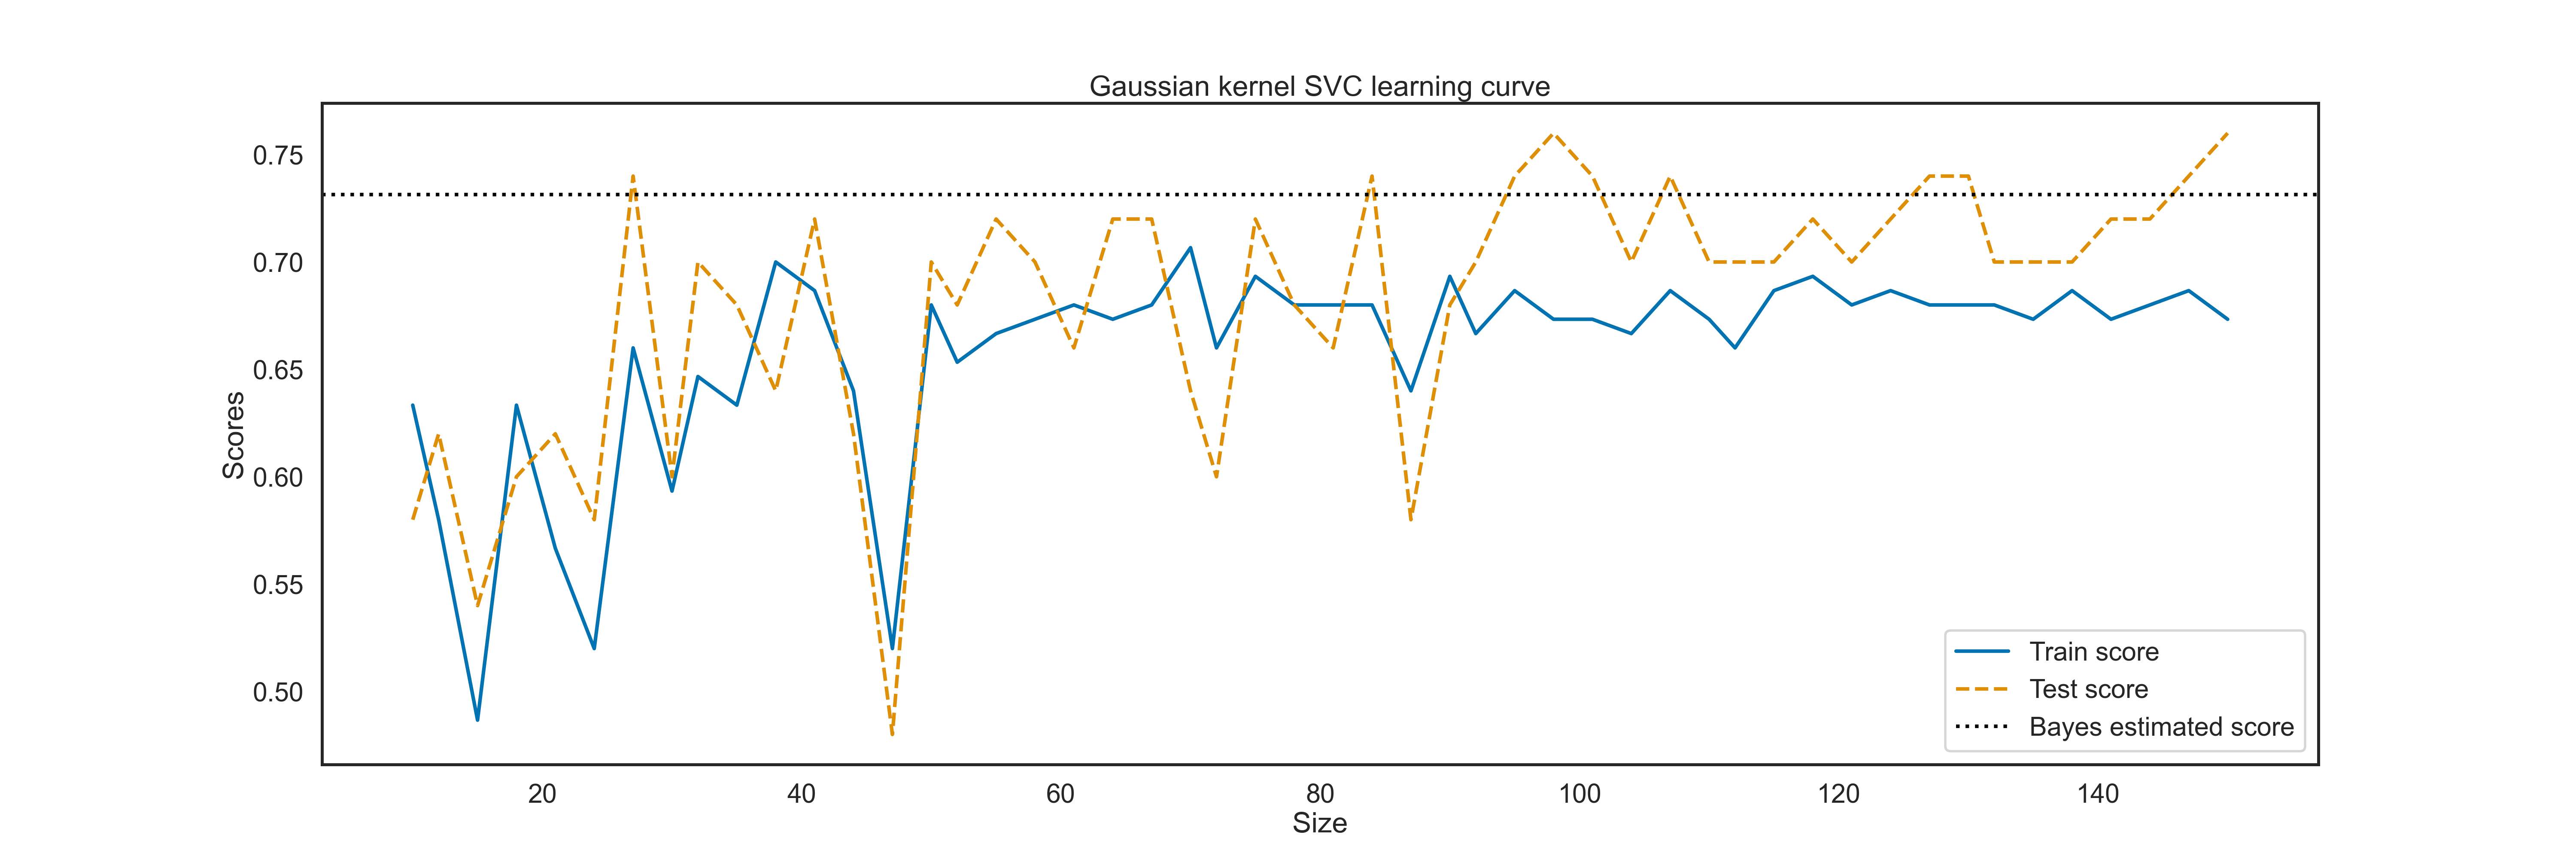

In [388]:
# Vary the parameter of the kernel and check the difference between training and testing scores
plt.close('all')
C = 1
gamma = 0.1
size = np.linspace(10, len(X_train)).astype(int)

traning_score=[]
test_score=[]

for i in size:
    rand_index = np.random.choice(np.arange(len(X_train)), size=i, replace=False)
    lsvm = SVC(kernel='rbf', C=c, gamma=gamma)
    lsvm.fit(X_train[rand_index],y_train[rand_index])
    # Score in the train set
    traning_score.append(lsvm.score(X_train,y_train))
    # Score in the test set
    test_score.append(lsvm.score(X_test,y_test))

#traning_score, test_score = zip(*sorted(zip(traning_score, test_score),reverse=True))

plt.figure(figsize=(15,5))
plt.plot(size,traning_score, label="Train score")
plt.plot(size,test_score, label="Test score", ls='--')
plt.axhline(1 - bayes_naive, label='Bayes estimated score', ls=':', color='black')
plt.legend()
plt.xlabel('Size')
plt.ylabel('Scores')
plt.title('Gaussian kernel SVC learning curve')

plt.show()

**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


<blockquote> The hyperparameter was varied from 0 to 10 and the amount of noisy labels was maintained at 20, a third of the total amount of labels. The model was trained and obtained a much higher rating for the test set at lower values of the hyperparameter, as it, and subsequently, the complexity, went up the train and test score tended to the same value. 

<IPython.core.display.Javascript object>


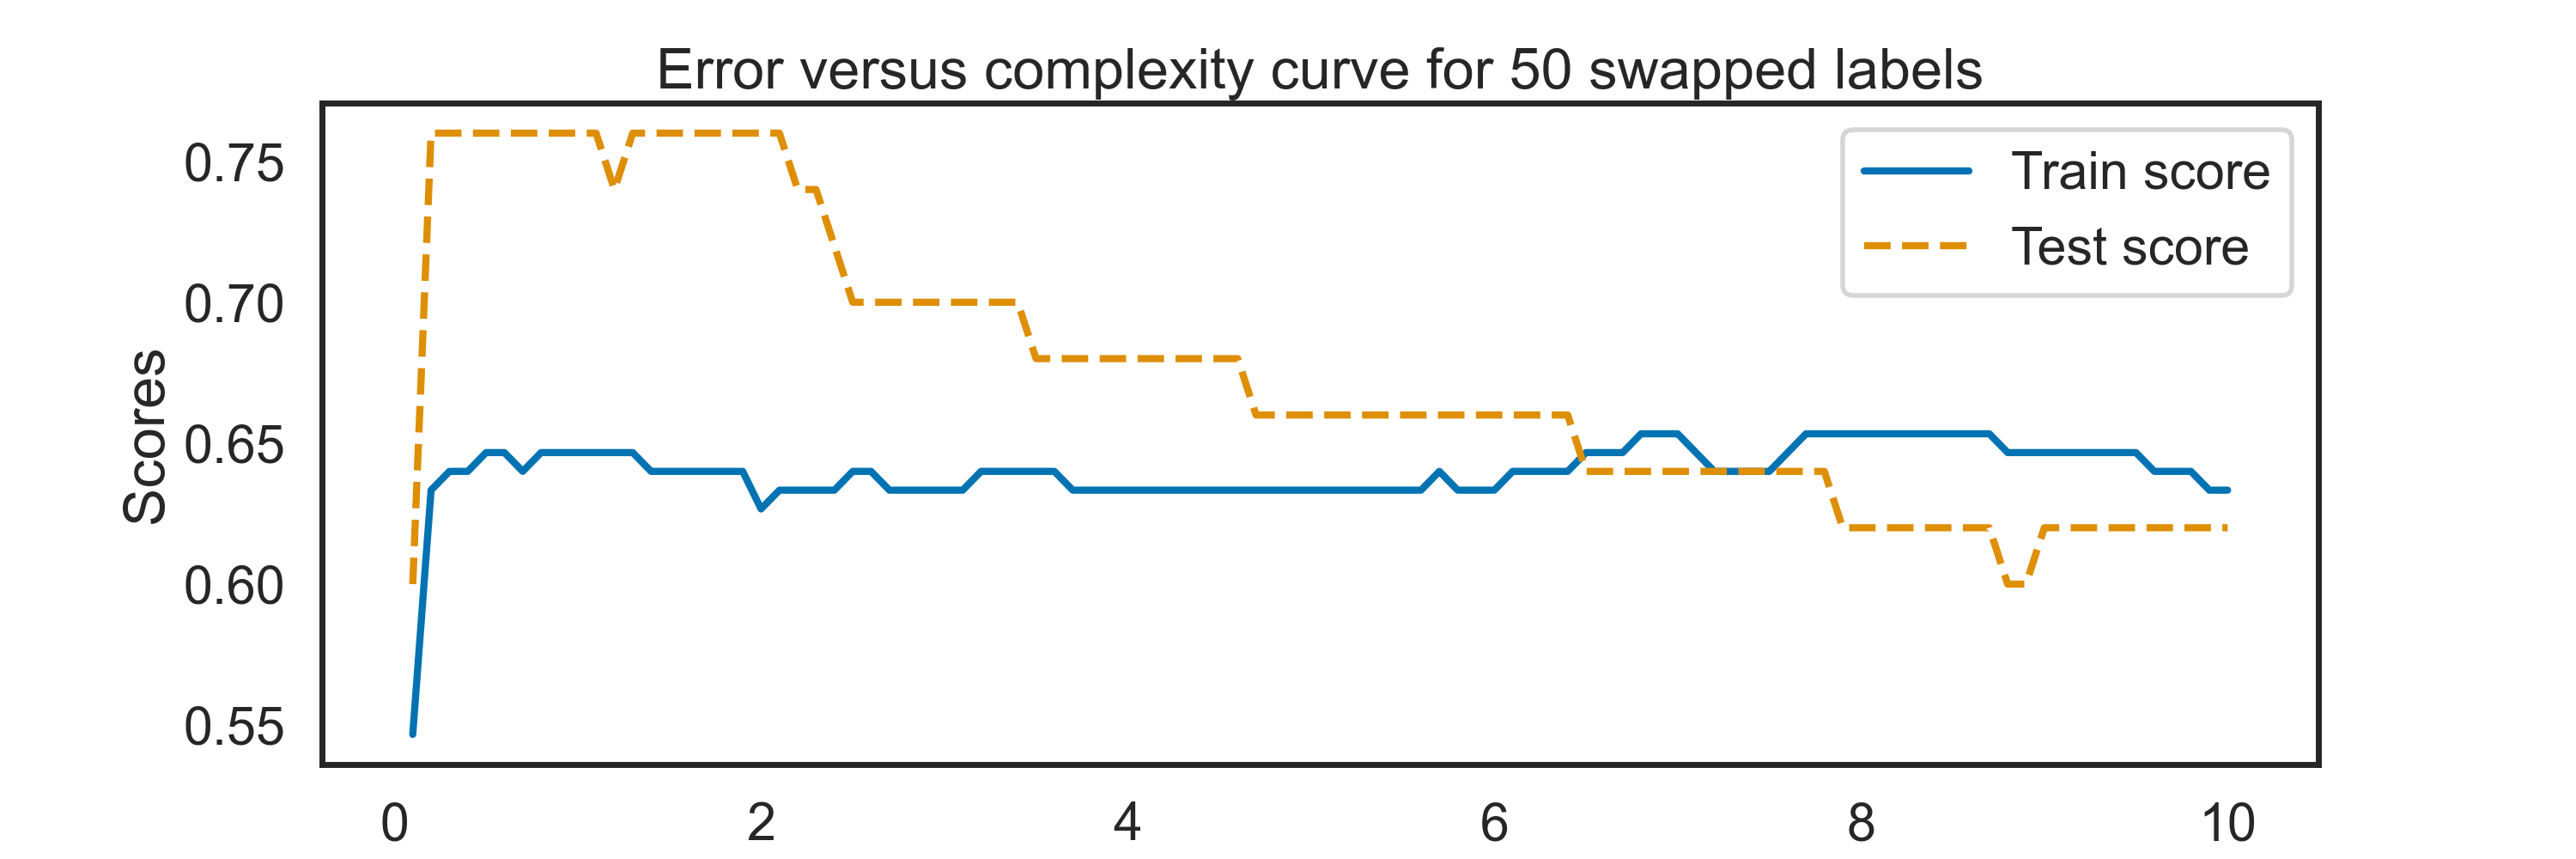

In [386]:
# Modify the class of some data points randomly
noise_index = np.random.choice(np.arange(len(y_train)), size=20, replace=False)
y_train_noise = y_train.copy()

traning_score=[]
test_score=[]

for i in noise_index:
    y_train_noise[i] = 1 - y_train[i]

C = np.linspace(0.1, 10, 100)
complexity = []

for i in C:
    lsvm = SVC(kernel='rbf', C=i)
    lsvm.fit(X_train,y_train_noise)
    # Score in the train set
    traning_score.append(lsvm.score(X_train,y_train_noise))
    # Score in the test set
    test_score.append(lsvm.score(X_test,y_test))
    complexity.append(lsvm.n_support_.sum())
    

plt.figure(figsize=(15,5))
plt.xlabel('Size')
plt.ylabel('Scores')
plt.plot(C,traning_score, label="Train score")
plt.plot(C,test_score, label="Test score", ls='--')
plt.legend(loc=1)

plt.title('Error versus complexity curve for 50 swapped labels')

plt.show()

## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_
examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regula-
rization parameter C.

**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

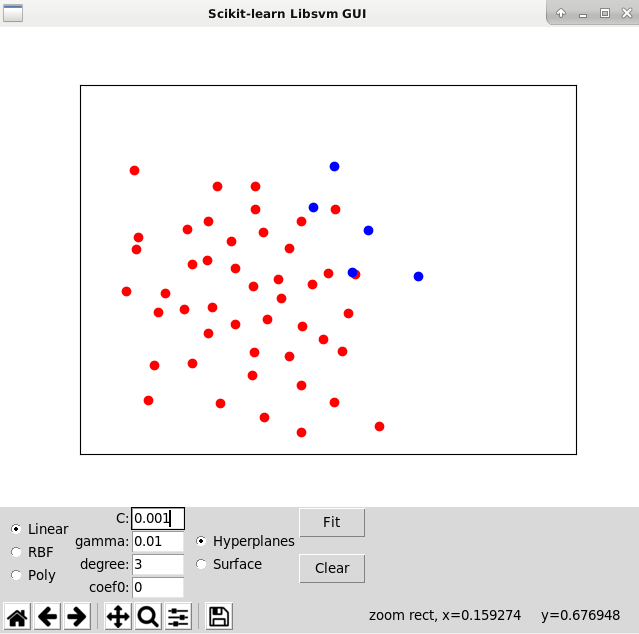

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

<blockquote> While decreasing the parameter C, it is observed that the resulting division hyperplane progressively distances from the dataset points, therefore increasing the error for the less frequent class points. <br>
    
This is expected, as the parameter C indicates the weight of an error. When C is decreased, making a large error is acceptable, as the classes are unbalanced.


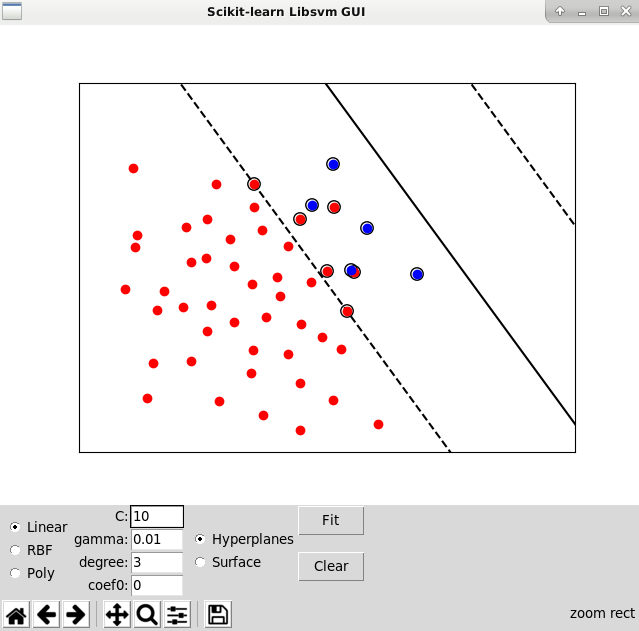

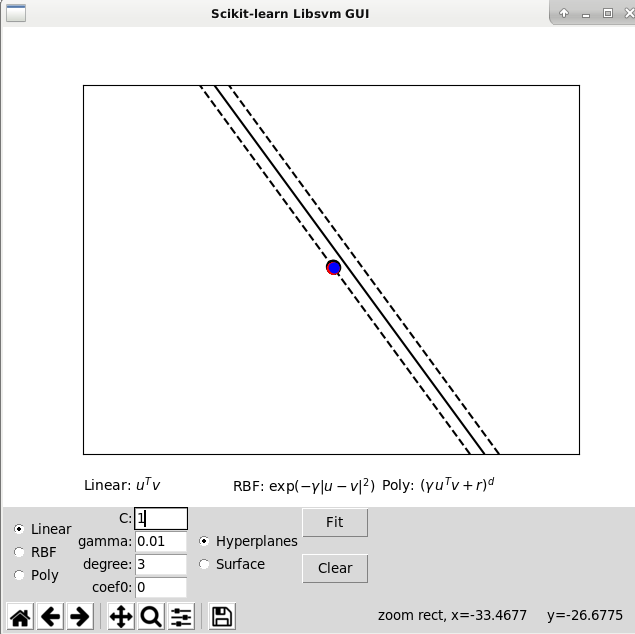

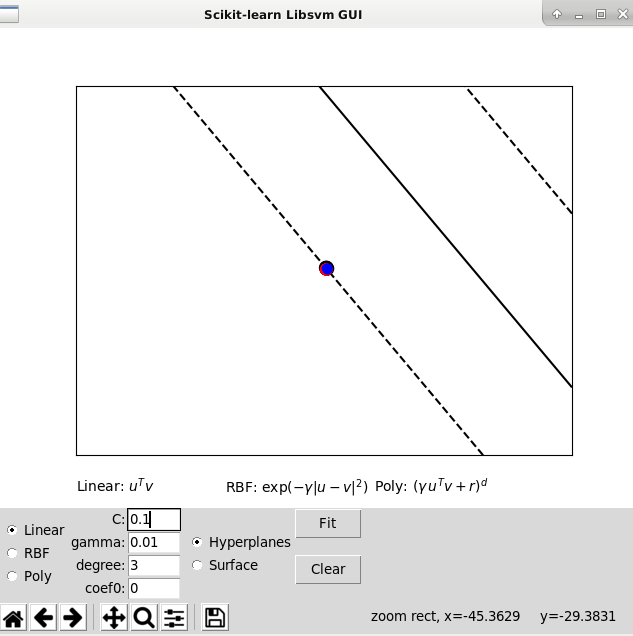

## Going further : application to face classification

Code for downloading and organizing the data:

In [ ]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

<blockquote> As can be seen in the graph bellow, the parameter C influences out test score (therefor the error). A really small C gives poor results. As C increases the test score also increases (the error decreases), until a point where the results became stable.

Fitting the classifier to the training set


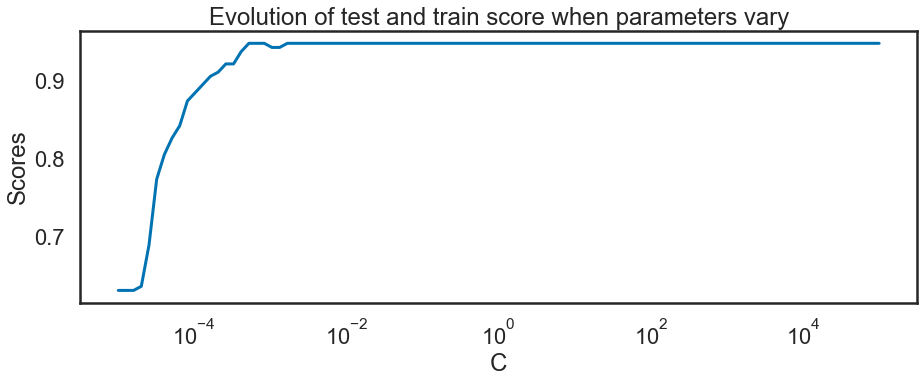

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

C= np.logspace(np.log10(1e-5), np.log10(1e5), 100)
scores = []

for c in C:
    clf = svm.SVC(kernel="linear")
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

plt.figure(figsize=(15,5))
plt.plot(C,scores)
plt.xscale("log")
plt.xlabel('C')
plt.ylabel('Scores')
plt.title('Evolution of test score when parameters vary')

plt.show()

In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.548s
Chance level : 0.6210526315789474
Accuracy : 0.9473684210526315


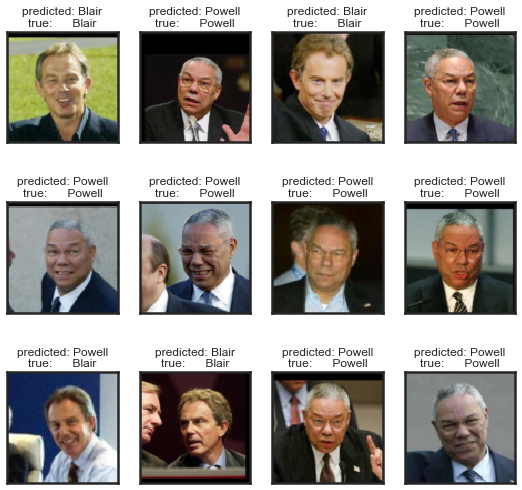

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

**18)** Explain why the features are centered and reduced.

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

Before adding nuisance variable
X_train shape:  (190, 10000)
X_test shape:  (190, 10000)
Fitting the classifier to the training set:
Accuracy: 0.9473684210526315


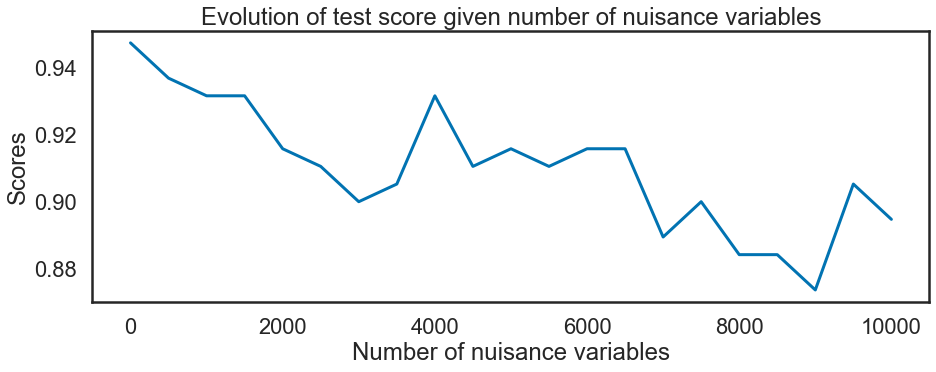

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
scores=[]
num = np.arange(0,10001,500)

print("Before adding nuisance variable")
print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)

print("Fitting the classifier to the training set:")

clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Accuracy: %s" % score)

for i in num:
    nuisance1 = np.random.randn(X_train.shape[0],i)
    nuisance2 = np.random.randn(X_train.shape[0],i)
    X_train_nuisance= np.append(X_train,nuisance1,axis=1)
    X_test_nuisance= np.append(X_test,nuisance2,axis=1)

    clf = svm.SVC(kernel="linear")
    clf.fit(X_train_nuisance, y_train)
    score = clf.score(X_test_nuisance, y_test)
    scores.append(score)

plt.figure(figsize=(15,5))
plt.plot(num,scores)
plt.xlabel('Number of nuisance variables')
plt.ylabel('Scores')
plt.title('Evolution of test score given number of nuisance variables')

plt.show()

<blockquote> <b>17)</b>Above the graph shows the relation between the number of nuisance variables and the test score. The nuisance variables were generated randomly, so this explains why its not a strictly descending curve. However, the tendency is that as the number of nuisance variables increases, the score decreases, which is expected.<br>
    
<b>18)</b> Usually it is interisting to center and reduce the data because if a feature is way bigger than he others, it might dominate the objective function and make the model unable to correctly learn from the other features.
If the data was mesuared by the same calibrated equipament, by the same method/person, usually there would be no need to scale/normalize it.

<b>19)</b> Using the RBF kernel, the results are more unstable. Choosing bad parameters can give really poor results. In our problem, due to the high dimension, finding a good set of parameters takes a lot of time. This can be solved applying PCA before the SVM, which will make computations faster and won’t compromise the results.

In [ ]:
from sklearn import decomposition
print("Before PCA: ")
print('Number of subjects N is: ', X_train.shape[0], ' ; number of features is: ',  X_train.shape[1] )

####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")

# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
lsvm = SVC(kernel='rbf')
grid_lsvm = GridSearchCV(lsvm, p_grid_lsvm, cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("Best test params: ", grid_lsvm.score(X_test,y_test))


pca = decomposition.PCA(n_components=0.9) # using number of components that explain 90% of variability as in last TP
X_train_pca = pca.fit_transform(X_train)

print("\nAfter PCA: ")
print('Number of subjects N is: ', X_train_pca.shape[0], ' ; number of features is: ',  X_train_pca.shape[1] )

X_test_pca = pca.transform(X_test)


####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")

grid_lsvm = GridSearchCV(lsvm, p_grid_lsvm, cv=5)
grid_lsvm.fit(X_train_pca, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("Best test params: ", grid_lsvm.score(X_test_pca,y_test))

Before PCA: 
Number of subjects N is:  190  ; number of features is:  10000
Fitting the classifier to the training set
Best training Score: 0.8157894736842105
Best training params: {'C': 3, 'gamma': 0.0001}
Best test params:  0.9210526315789473

After PCA: 
Number of subjects N is:  190  ; number of features is:  64
Fitting the classifier to the training set
Best training Score: 0.8315789473684211
Best training params: {'C': 8, 'gamma': 0.0001}
Best test params:  0.8947368421052632
